<a href="https://colab.research.google.com/github/byeongchan1/Adv-ALSTM/blob/master/practice20211104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

!pip install torchmetrics
import torchmetrics

!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Mounted at /content/gdrive
     |████████████████████████████████| 329 kB 5.2 MB/s 


# 1. 데이터 전처리

In [2]:
# data path 지정
raw_data_path = './Adv-ALSTM/data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [3]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [4]:
feature_data_path = './Adv-ALSTM/data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



# train, validation, test data 나누기

## 1. input data 3차원으로 쌓기
shape = (stock 종류수, date, feature)



요건
1. 모든 티커 데이터의 date가 맞는지?
2. 결측치는 없는지?
3. 티커와 데이터 메치 가능해야함

In [5]:
raw_data_path = './Adv-ALSTM/data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

# 마지막에 index 종목 넣기
raw_data_index_path = './Adv-ALSTM/data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X

ticker : SPLP.csv, date check : True
ticker : CELG.csv, date check : True
ticker : WFC.csv, date check : True
ticker : INTC.csv, date check : True
ticker : JNJ.csv, date check : True
ticker : AAPL.csv, date check : True
ticker : GOOG.csv, date check : True
ticker : BP.csv, date check : True
ticker : GE.csv, date check : True
ticker : BABA.csv, date check : False
ticker : PTR.csv, date check : True
ticker : AMZN.csv, date check : True
ticker : SLB.csv, date check : True
ticker : SRE.csv, date check : True
ticker : KO.csv, date check : True
ticker : UTX.csv, date check : True
ticker : BHP.csv, date check : True
ticker : BRK-A.csv, date check : True
ticker : NEE.csv, date check : True
ticker : DHR.csv, date check : True
ticker : BBL.csv, date check : True
ticker : CVX.csv, date check : True
ticker : NVS.csv, date check : True
ticker : CAT.csv, date check : True
ticker : PICO.csv, date check : True
ticker : VZ.csv, date check : True
ticker : AEP.csv, date check : True
ticker : T.csv, date 

In [6]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [7]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

## Hyperparameter setting

In [8]:
w = 10 # window size w in {10, 15}
beta = 0.01 # market context weight beta in {0.01, 0.1, 1}
h = 64 # hidden layer size h in {64, 128}
learning_rate = 0.001 # in {0.001, 0.0001}
lambda_1 = 1 # selective regularzation lambda = 1
drop_rate = 0.15
feature_size = len(COLUMNS_FEATURE)

In [9]:
class Feature_transformation_layer(nn.Module):
    """Feature transformation layer in DTML"""

    def __init__(self, feature_size, h):
        super(Feature_transformation_layer, self).__init__()
        self.feature_size = feature_size
        self.h = h

        self.linear = nn.Linear(self.feature_size, self.h)
    
    def forward(self, X):
        output = torch.tanh(self.linear(X))
        return output

In [10]:
def layer_normalization(tensor):
    h = tensor.size()[-1]
    return (tensor - torch.std_mean(tensor, dim=1, unbiased=False)[1].repeat((h,1)).transpose(-2,-1))/torch.std_mean(tensor, dim=1, unbiased=False)[0].repeat((h,1)).transpose(-2,-1)

In [11]:
class Nonlinear_transformation(nn.Module):
    """Nonlinear transformation in DTML"""

    def __init__(self, h):
        super(Nonlinear_transformation, self).__init__()
        self.h = h


        self.mlp1 = nn.Linear(self.h, self.h * 4)
        self.mlp2 = nn.Linear(self.h * 4, h)
    
    def forward(self, H, H_tilda):
        H_p = H + H_tilda
        H_p = self.mlp1(H_p)
        H_p = nn.ReLU()(H_p)
        H_p = self.mlp2(H_p)
        H_p = H + H_tilda + H_p
        H_p = nn.Tanh()(H_p)

        # dropout and layer normalization
        H_p = nn.Dropout(p=drop_rate)(H_p)
        H_p = layer_normalization(H_p)
        return H_p

In [12]:
class Final_prediction(nn.Module):
    """final prediction in DTML"""

    def __init__(self, h):
        super(Final_prediction, self).__init__()
        self.h = h

        self.pred_linear = nn.Linear(h,1)
    
    def forward(self, H_p):
        y_hat = self.pred_linear(H_p)
        y_hat = nn.Sigmoid()(y_hat).view((-1))

        return y_hat

In [33]:
class DTML(nn.Module):
    ''' DTML '''

    def __init__(self, X, y, w, h, beta, test_X, test_y,
                 batch_size,
                 learning_rate, epochs):
        """ Initialize """
        super(DTML, self).__init__()
        self.X = X
        self.y = y
        self.test_X = test_X
        self.test_y = test_y
        self.w = w
        self.h = h
        self.beta = beta
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.train_timesteps = train_timesteps = int(X.size()[1]) - w

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator : ", self.device)

        self.Feature_transformation_layer = Feature_transformation_layer(feature_size=self.X.size()[-1],
                                                                         h=self.h)
        
        # 티커별로 lstm 층 개별로 만들기
        for i in range(self.X.size()[0]): # 마지막은 index용 lstm
            self._modules['lstm_{}'.format(i)] = nn.LSTM(input_size = self.h, hidden_size=self.h, batch_first=True)
        
        # ticker별로 linear layer 생성
        for i in range(self.X.size()[0]):
            self._modules['ContextNormalLinearLayer_{}'.format(i)] = nn.Linear(h, h)

        self.query_layer = nn.Linear(self.h, self.h)
        self.key_layer = nn.Linear(self.h, self.h)
        self.value_layer = nn.Linear(self.h, self.h)

        self.Nonlinear_transformation = Nonlinear_transformation(h=self.h)

        self.Final_prediction = Final_prediction(h=self.h)

        # Loss funciton
        self.criterion = nn.BCELoss()

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.learning_rate)

    def window_(self, tensor, time_idx, window_size):
        # tensor size = (ticker_number, dates, feature_size)    
        return tensor[:, time_idx:time_idx + self.w, :]


    def train(self):
        """training process"""
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.iter_acc = np.zeros(self.epochs * iter_per_epoch)
        self.iter_mcc = np.zeros(self.epochs * iter_per_epoch)
        self.iter_precision = np.zeros(self.epochs * iter_per_epoch)
        self.return_rate = np.zeros((self.epochs, self.train_timesteps)) # batch_size 관련해서 수정필요
        self.com_return_rate = np.zeros((self.epochs, self.train_timesteps)) # batch_size 관련해서 수정필요
        # epoch당 loss
        self.epoch_losses = np.zeros(self.epochs)
        self.epoch_acc = np.zeros(self.epochs)
        self.epoch_mcc = np.zeros(self.epochs)
        self.epoch_precision = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            time_idx = 0
            com_return_rate = 1
            output = self.Feature_transformation_layer(self.X)

            while (time_idx < self.train_timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(self.y, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((self.X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(self.X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((self.X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(self.X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((self.X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(self.X.size()[0], self.h)
                for i in range(self.X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외

                Q = self.query_layer(H)
                K = self.key_layer(H)
                V = self.value_layer(H)

                # S 생성
                S = torch.matmul(Q, K.transpose(-2,-1))
                S = S/math.sqrt(h)
                S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation
                H_tilda = nn.Dropout(p=drop_rate)(H_tilda)
                H_tilda = layer_normalization(H_tilda)

                H_p = self.Nonlinear_transformation(H, H_tilda)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = self.X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                com_return_rate *= 1 + return_rate

                loss_reg.backward(retain_graph=True)
                self.optimizer.step()
              

                self.iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함

                if time_idx % 100 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)

                time_idx += self.batch_size
                n_iter += 1

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.epoch_acc[epoch] = np.mean(self.iter_acc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.epoch_mcc[epoch] = np.mean(self.iter_mcc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.epoch_precision[epoch] = np.mean(self.iter_precision[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            plt.figure()
            plt.plot(range(self.train_timesteps - w), self.com_return_rate[epoch][:self.train_timesteps - w])
            plt.show()

            if epoch % 10 == 0:
                print("Epochs : ", epoch, "Iterations : ", n_iter,
                      "Loss : ", self.epoch_losses[epoch],
                      "ACC : ", self.epoch_acc[epoch],
                      "MCC : ", self.epoch_mcc[epoch],
                      "Precision : ", self.epoch_precision[epoch])
    
    def test(self):
        timesteps = int(self.test_X.size()[1]) - w
        epochs = 1
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.iter_losses = np.zeros(epochs * iter_per_epoch)
        self.iter_acc = np.zeros(epochs * iter_per_epoch)
        self.iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.iter_precision = np.zeros(epochs * iter_per_epoch)
        self.return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요

        # epoch당 loss
        self.epoch_losses = np.zeros(epochs)
        self.epoch_acc = np.zeros(epochs)
        self.epoch_mcc = np.zeros(epochs)
        self.epoch_precision = np.zeros(epochs)

        n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            output = self.Feature_transformation_layer(self.test_X)

            while (time_idx < timesteps): # test끝으로 바꿔야함
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tes_data_Y_w = self.window_(self.test_y, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((self.test_X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(self.test_X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((self.test_X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(self.test_X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((self.test_X.size()[0], self.h))
                for i in range(self.test_X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(self.test_X.size()[0], self.h)
                for i in range(self.test_X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외

                Q = self.query_layer(H)
                K = self.key_layer(H)
                V = self.value_layer(H)

                # S 생성
                S = torch.matmul(Q, K.transpose(-2,-1))
                S = S/math.sqrt(h)
                S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation
                H_tilda = nn.Dropout(p=drop_rate)(H_tilda)
                H_tilda = layer_normalization(H_tilda)

                H_p = self.Nonlinear_transformation(H, H_tilda)

                y_hat = self.Final_prediction(H_p)
                y = tes_data_Y_w[:,w-1,:].view((-1))

                # self.optimizer.zero_grad()
                # test에서는 학습할 필요 없어요

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = self.X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                com_return_rate *= 1 + return_rate

                # test에서는 학습할 필요 없어요
                # loss_reg.backward(retain_graph=True)
                # self.optimizer.step()              

                self.iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함

                if time_idx % 100 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision)

                time_idx += self.batch_size
                n_iter += 1

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.epoch_acc[epoch] = np.mean(self.iter_acc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.epoch_mcc[epoch] = np.mean(self.iter_mcc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.epoch_precision[epoch] = np.mean(self.iter_precision[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                # 수익률 계산
                # 수정종가에 매수, 익일 수정종가에 매도
                # adjclose_lastadjclose_ratio 으로 계산 (5번째 있는 column / index는 4)
                # Weight = 동일가중
                # 오를 확률이 제일 높은 3개 Ticker 매수 후, 익일 매도

            plt.figure()
            plt.plot(range(timesteps - w), self.com_return_rate[0][ : timesteps - w])
            plt.show()    


            if epoch % 10 == 0:
                print("Epochs : ", epoch, "Iterations : ", n_iter,
                      "Loss : ", self.epoch_losses[epoch],
                      "ACC : ", self.epoch_acc[epoch],
                      "MCC : ", self.epoch_mcc[epoch],
                      "Precision : ", self.epoch_precision[epoch])


                

In [34]:
model = DTML(
    X=tensor_tra_data_X,
    y=tensor_tra_data_Y,
    test_X = tensor_test_data_X,
    test_y=tensor_test_data_Y,
     w=w, h=h, batch_size=1, beta = 0.01,
     learning_rate=learning_rate, epochs=100)

==> Use accelerator :  cpu


In [35]:
summary(model)

Layer (type:depth-idx)                   Param #
DTML                                     --
├─Feature_transformation_layer: 1-1      --
│    └─Linear: 2-1                       768
├─LSTM: 1-2                              33,280
├─LSTM: 1-3                              33,280
├─LSTM: 1-4                              33,280
├─LSTM: 1-5                              33,280
├─LSTM: 1-6                              33,280
├─LSTM: 1-7                              33,280
├─LSTM: 1-8                              33,280
├─LSTM: 1-9                              33,280
├─LSTM: 1-10                             33,280
├─LSTM: 1-11                             33,280
├─LSTM: 1-12                             33,280
├─LSTM: 1-13                             33,280
├─LSTM: 1-14                             33,280
├─LSTM: 1-15                             33,280
├─LSTM: 1-16                             33,280
├─LSTM: 1-17                             33,280
├─LSTM: 1-18                             33,280
├─

epoch :  0 time_idx :  0 loss_reg :  tensor(1.0299, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0747) precision :  tensor(0.5238) return_rate tensor(-0.0012) com_return_rate tensor(0.9988)
epoch :  0 time_idx :  100 loss_reg :  tensor(0.8313, grad_fn=<AddBackward0>) acc :  tensor(0.2118) mcc :  tensor(-0.0351) precision :  tensor(0.1852) return_rate tensor(-0.0009) com_return_rate tensor(1.2216)
epoch :  0 time_idx :  200 loss_reg :  tensor(0.7122, grad_fn=<AddBackward0>) acc :  tensor(0.3647) mcc :  tensor(-0.0906) precision :  tensor(0.8710) return_rate tensor(0.0138) com_return_rate tensor(1.1927)
epoch :  0 time_idx :  300 loss_reg :  tensor(0.6994, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.1267) precision :  tensor(1.) return_rate tensor(0.0055) com_return_rate tensor(1.3777)


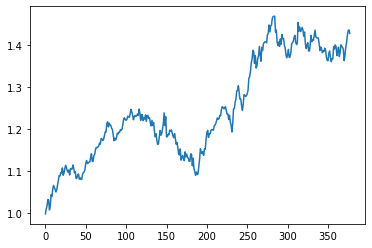

Epochs :  0 Iterations :  388 Loss :  0.7515497585547339 ACC :  0.4849909168269639 MCC :  nan Precision :  0.457336104256533
epoch :  1 time_idx :  0 loss_reg :  tensor(0.6918, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0708) precision :  tensor(0.6000) return_rate tensor(-0.0018) com_return_rate tensor(0.9982)
epoch :  1 time_idx :  100 loss_reg :  tensor(0.7455, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0059) com_return_rate tensor(1.0632)
epoch :  1 time_idx :  200 loss_reg :  tensor(0.7000, grad_fn=<AddBackward0>) acc :  tensor(0.1294) mcc :  tensor(0.0617) precision :  tensor(1.) return_rate tensor(0.0054) com_return_rate tensor(1.2911)
epoch :  1 time_idx :  300 loss_reg :  tensor(0.6961, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(nan) precision :  tensor(0.) return_rate tensor(0.0001) com_return_rate tensor(1.3212)


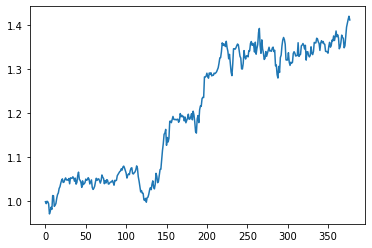

epoch :  2 time_idx :  0 loss_reg :  tensor(0.6896, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1149) precision :  tensor(0.6667) return_rate tensor(0.0052) com_return_rate tensor(1.0052)
epoch :  2 time_idx :  100 loss_reg :  tensor(0.7374, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0052) com_return_rate tensor(1.1715)
epoch :  2 time_idx :  200 loss_reg :  tensor(0.6975, grad_fn=<AddBackward0>) acc :  tensor(0.2706) mcc :  tensor(-0.4254) precision :  tensor(0.7419) return_rate tensor(0.0031) com_return_rate tensor(1.3900)
epoch :  2 time_idx :  300 loss_reg :  tensor(0.6942, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(-0.0976) precision :  tensor(0.5429) return_rate tensor(0.0101) com_return_rate tensor(1.3483)


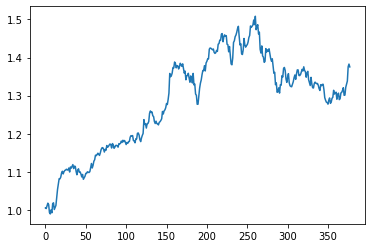

epoch :  3 time_idx :  0 loss_reg :  tensor(0.6837, grad_fn=<AddBackward0>) acc :  tensor(0.6588) mcc :  tensor(0.3091) precision :  tensor(0.6786) return_rate tensor(0.0052) com_return_rate tensor(1.0052)
epoch :  3 time_idx :  100 loss_reg :  tensor(0.7168, grad_fn=<AddBackward0>) acc :  tensor(0.3059) mcc :  tensor(0.1088) precision :  tensor(0.2055) return_rate tensor(-0.0054) com_return_rate tensor(0.9635)
epoch :  3 time_idx :  200 loss_reg :  tensor(0.6986, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(-0.1804) precision :  tensor(0.8500) return_rate tensor(0.0090) com_return_rate tensor(1.0979)
epoch :  3 time_idx :  300 loss_reg :  tensor(0.6958, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(-0.1352) precision :  tensor(0.5263) return_rate tensor(0.0069) com_return_rate tensor(1.1216)


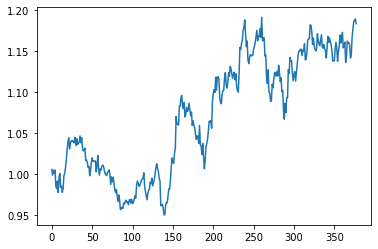

epoch :  4 time_idx :  0 loss_reg :  tensor(0.6859, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2233) precision :  tensor(0.5714) return_rate tensor(0.0019) com_return_rate tensor(1.0019)
epoch :  4 time_idx :  100 loss_reg :  tensor(0.7154, grad_fn=<AddBackward0>) acc :  tensor(0.3882) mcc :  tensor(0.1363) precision :  tensor(0.2188) return_rate tensor(-0.0098) com_return_rate tensor(1.1093)
epoch :  4 time_idx :  200 loss_reg :  tensor(0.7028, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(-0.1883) precision :  tensor(0.8462) return_rate tensor(-0.0019) com_return_rate tensor(1.3403)
epoch :  4 time_idx :  300 loss_reg :  tensor(0.6946, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(-0.0920) precision :  tensor(0.5357) return_rate tensor(0.0061) com_return_rate tensor(1.2686)


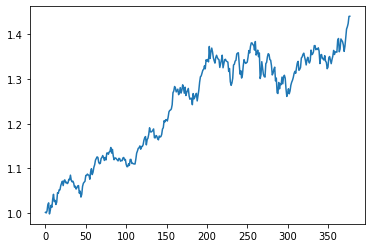

epoch :  5 time_idx :  0 loss_reg :  tensor(0.6862, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1252) precision :  tensor(0.5250) return_rate tensor(0.0041) com_return_rate tensor(1.0041)
epoch :  5 time_idx :  100 loss_reg :  tensor(0.7113, grad_fn=<AddBackward0>) acc :  tensor(0.3882) mcc :  tensor(0.1861) precision :  tensor(0.2273) return_rate tensor(-0.0045) com_return_rate tensor(1.1870)
epoch :  5 time_idx :  200 loss_reg :  tensor(0.7018, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(-0.2612) precision :  tensor(0.8250) return_rate tensor(0.0005) com_return_rate tensor(1.3973)
epoch :  5 time_idx :  300 loss_reg :  tensor(0.6955, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(0.0613) precision :  tensor(0.6429) return_rate tensor(-0.0016) com_return_rate tensor(1.3787)


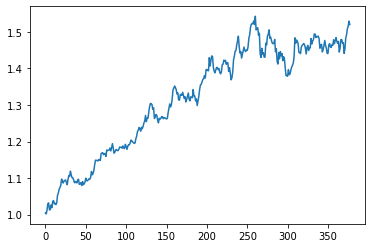

epoch :  6 time_idx :  0 loss_reg :  tensor(0.6849, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1761) precision :  tensor(0.5476) return_rate tensor(0.0069) com_return_rate tensor(1.0069)
epoch :  6 time_idx :  100 loss_reg :  tensor(0.7110, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(0.1578) precision :  tensor(0.2258) return_rate tensor(-0.0080) com_return_rate tensor(1.1162)
epoch :  6 time_idx :  200 loss_reg :  tensor(0.7009, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(-0.3261) precision :  tensor(0.8095) return_rate tensor(-0.0008) com_return_rate tensor(1.2913)
epoch :  6 time_idx :  300 loss_reg :  tensor(0.6933, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.0292) precision :  tensor(0.5833) return_rate tensor(0.0059) com_return_rate tensor(1.3933)


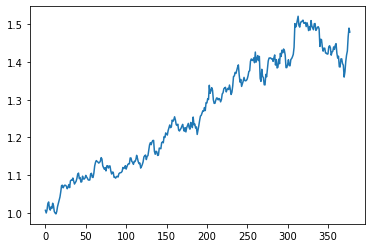

epoch :  7 time_idx :  0 loss_reg :  tensor(0.6820, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2233) precision :  tensor(0.5714) return_rate tensor(0.0041) com_return_rate tensor(1.0041)
epoch :  7 time_idx :  100 loss_reg :  tensor(0.7092, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.2158) precision :  tensor(0.2381) return_rate tensor(-0.0057) com_return_rate tensor(1.0757)
epoch :  7 time_idx :  200 loss_reg :  tensor(0.7023, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.2305) precision :  tensor(0.8409) return_rate tensor(-0.0008) com_return_rate tensor(1.1681)
epoch :  7 time_idx :  300 loss_reg :  tensor(0.6934, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.0481) precision :  tensor(0.5750) return_rate tensor(-0.0036) com_return_rate tensor(1.1535)


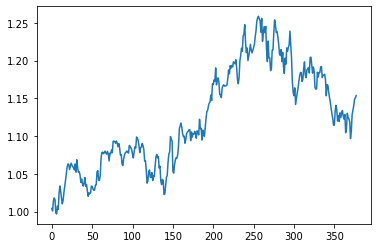

epoch :  8 time_idx :  0 loss_reg :  tensor(0.6842, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1072) precision :  tensor(0.5116) return_rate tensor(0.0045) com_return_rate tensor(1.0045)
epoch :  8 time_idx :  100 loss_reg :  tensor(0.7089, grad_fn=<AddBackward0>) acc :  tensor(0.3882) mcc :  tensor(0.1861) precision :  tensor(0.2273) return_rate tensor(-0.0077) com_return_rate tensor(1.1232)
epoch :  8 time_idx :  200 loss_reg :  tensor(0.7037, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(-0.1804) precision :  tensor(0.8500) return_rate tensor(-0.0002) com_return_rate tensor(1.3261)
epoch :  8 time_idx :  300 loss_reg :  tensor(0.6918, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0580) precision :  tensor(0.6316) return_rate tensor(0.0010) com_return_rate tensor(1.2381)


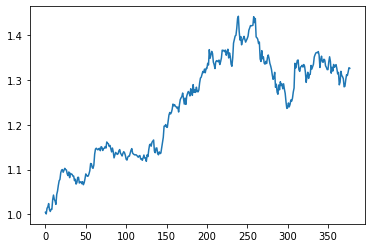

epoch :  9 time_idx :  0 loss_reg :  tensor(0.6855, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1329) precision :  tensor(0.5227) return_rate tensor(0.0031) com_return_rate tensor(1.0031)
epoch :  9 time_idx :  100 loss_reg :  tensor(0.7039, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(0.2255) precision :  tensor(0.2419) return_rate tensor(0.0012) com_return_rate tensor(1.1385)
epoch :  9 time_idx :  200 loss_reg :  tensor(0.7064, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.1650) precision :  tensor(0.8571) return_rate tensor(-0.0008) com_return_rate tensor(1.3441)
epoch :  9 time_idx :  300 loss_reg :  tensor(0.6928, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(0.0613) precision :  tensor(0.6429) return_rate tensor(0.0130) com_return_rate tensor(1.3803)


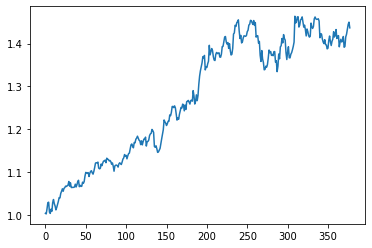

epoch :  10 time_idx :  0 loss_reg :  tensor(0.6859, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.1979) precision :  tensor(0.5610) return_rate tensor(0.0043) com_return_rate tensor(1.0043)
epoch :  10 time_idx :  100 loss_reg :  tensor(0.7052, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.1683) precision :  tensor(0.2295) return_rate tensor(-0.0089) com_return_rate tensor(1.1836)
epoch :  10 time_idx :  200 loss_reg :  tensor(0.7017, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.2305) precision :  tensor(0.8409) return_rate tensor(-0.0002) com_return_rate tensor(1.5379)
epoch :  10 time_idx :  300 loss_reg :  tensor(0.6937, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.0595) precision :  tensor(0.5625) return_rate tensor(0.0053) com_return_rate tensor(1.5819)


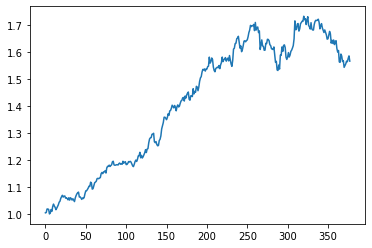

Epochs :  10 Iterations :  4268 Loss :  0.6929280094264709 ACC :  0.5227107505515679 MCC :  0.0545900670113042 Precision :  0.5316785243387843
epoch :  11 time_idx :  0 loss_reg :  tensor(0.6845, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0057) com_return_rate tensor(1.0057)
epoch :  11 time_idx :  100 loss_reg :  tensor(0.7059, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(0.1127) precision :  tensor(0.2167) return_rate tensor(-0.0063) com_return_rate tensor(1.1757)
epoch :  11 time_idx :  200 loss_reg :  tensor(0.7009, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(-0.3111) precision :  tensor(0.8182) return_rate tensor(-0.0008) com_return_rate tensor(1.4303)
epoch :  11 time_idx :  300 loss_reg :  tensor(0.6950, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(-0.0203) precision :  tensor(0.5862) return_rate tensor(0.0032) com_return_rate tensor(1.3641)


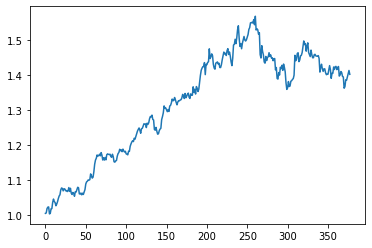

epoch :  12 time_idx :  0 loss_reg :  tensor(0.6838, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2233) precision :  tensor(0.5714) return_rate tensor(0.0057) com_return_rate tensor(1.0057)
epoch :  12 time_idx :  100 loss_reg :  tensor(0.7035, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(0.1561) precision :  tensor(0.2321) return_rate tensor(-0.0020) com_return_rate tensor(1.1332)
epoch :  12 time_idx :  200 loss_reg :  tensor(0.6995, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(-0.3039) precision :  tensor(0.8222) return_rate tensor(-0.0027) com_return_rate tensor(1.3693)
epoch :  12 time_idx :  300 loss_reg :  tensor(0.6913, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.1444) precision :  tensor(0.7037) return_rate tensor(0.0130) com_return_rate tensor(1.3202)


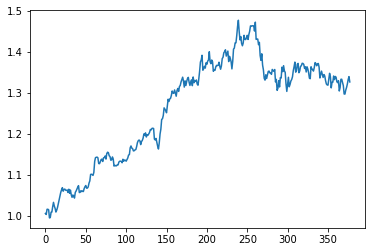

epoch :  13 time_idx :  0 loss_reg :  tensor(0.6835, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0043) com_return_rate tensor(1.0043)
epoch :  13 time_idx :  100 loss_reg :  tensor(0.7072, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(0.2255) precision :  tensor(0.2419) return_rate tensor(-0.0097) com_return_rate tensor(1.0832)
epoch :  13 time_idx :  200 loss_reg :  tensor(0.7032, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(-0.3111) precision :  tensor(0.8182) return_rate tensor(0.0027) com_return_rate tensor(1.2654)
epoch :  13 time_idx :  300 loss_reg :  tensor(0.6945, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.0409) precision :  tensor(0.5714) return_rate tensor(0.0090) com_return_rate tensor(1.3680)


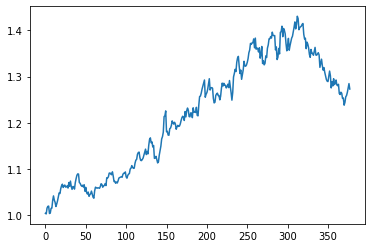

epoch :  14 time_idx :  0 loss_reg :  tensor(0.6839, grad_fn=<AddBackward0>) acc :  tensor(0.5765) mcc :  tensor(0.1586) precision :  tensor(0.5333) return_rate tensor(0.0057) com_return_rate tensor(1.0057)
epoch :  14 time_idx :  100 loss_reg :  tensor(0.7062, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(0.1346) precision :  tensor(0.2241) return_rate tensor(-0.0084) com_return_rate tensor(1.0677)
epoch :  14 time_idx :  200 loss_reg :  tensor(0.7024, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(-0.2898) precision :  tensor(0.8298) return_rate tensor(-0.0008) com_return_rate tensor(1.2518)
epoch :  14 time_idx :  300 loss_reg :  tensor(0.6924, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(0.0397) precision :  tensor(0.6250) return_rate tensor(0.0045) com_return_rate tensor(1.2563)


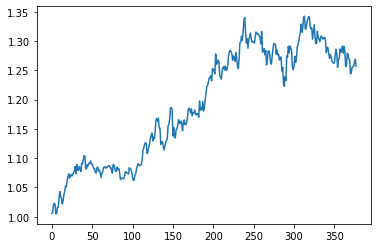

epoch :  15 time_idx :  0 loss_reg :  tensor(0.6819, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0043) com_return_rate tensor(1.0043)
epoch :  15 time_idx :  100 loss_reg :  tensor(0.7065, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.1237) precision :  tensor(0.2203) return_rate tensor(-0.0022) com_return_rate tensor(1.1250)
epoch :  15 time_idx :  200 loss_reg :  tensor(0.7023, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2830) precision :  tensor(0.8333) return_rate tensor(-0.0002) com_return_rate tensor(1.3182)
epoch :  15 time_idx :  300 loss_reg :  tensor(0.6931, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(0.0304) precision :  tensor(0.6207) return_rate tensor(0.0069) com_return_rate tensor(1.3480)


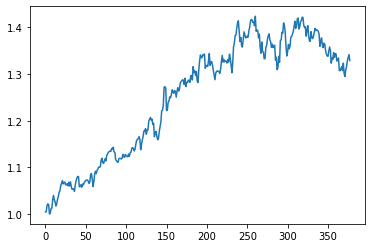

epoch :  16 time_idx :  0 loss_reg :  tensor(0.6821, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.2451) precision :  tensor(0.5854) return_rate tensor(0.0059) com_return_rate tensor(1.0059)
epoch :  16 time_idx :  100 loss_reg :  tensor(0.7047, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(0.1037) precision :  tensor(0.2182) return_rate tensor(-0.0084) com_return_rate tensor(1.1487)
epoch :  16 time_idx :  200 loss_reg :  tensor(0.7006, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2697) precision :  tensor(0.8400) return_rate tensor(0.0009) com_return_rate tensor(1.3138)
epoch :  16 time_idx :  300 loss_reg :  tensor(0.6937, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(0.0102) precision :  tensor(0.6071) return_rate tensor(0.0069) com_return_rate tensor(1.3721)


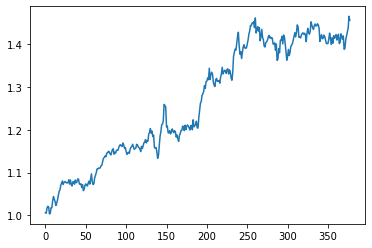

epoch :  17 time_idx :  0 loss_reg :  tensor(0.6830, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0035) com_return_rate tensor(1.0035)
epoch :  17 time_idx :  100 loss_reg :  tensor(0.7046, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(0.1993) precision :  tensor(0.2414) return_rate tensor(-0.0054) com_return_rate tensor(1.2530)
epoch :  17 time_idx :  200 loss_reg :  tensor(0.6992, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2697) precision :  tensor(0.8400) return_rate tensor(0.0064) com_return_rate tensor(1.6016)
epoch :  17 time_idx :  300 loss_reg :  tensor(0.6935, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(0.0304) precision :  tensor(0.6207) return_rate tensor(0.0082) com_return_rate tensor(1.6407)


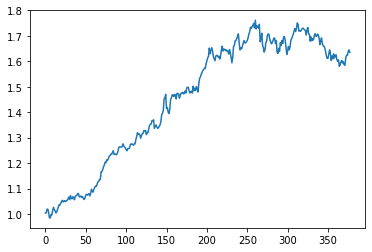

epoch :  18 time_idx :  0 loss_reg :  tensor(0.6837, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0050) com_return_rate tensor(1.0050)
epoch :  18 time_idx :  100 loss_reg :  tensor(0.7057, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(0.1454) precision :  tensor(0.2281) return_rate tensor(-0.0126) com_return_rate tensor(1.2136)
epoch :  18 time_idx :  200 loss_reg :  tensor(0.6998, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.2632) precision :  tensor(0.8431) return_rate tensor(-0.0025) com_return_rate tensor(1.4823)
epoch :  18 time_idx :  300 loss_reg :  tensor(0.6929, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(0.) precision :  tensor(0.6000) return_rate tensor(0.0090) com_return_rate tensor(1.5326)


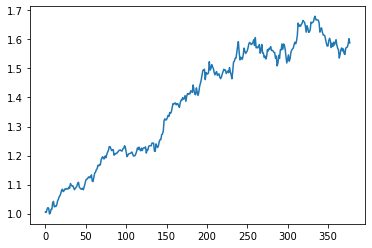

epoch :  19 time_idx :  0 loss_reg :  tensor(0.6845, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1801) precision :  tensor(0.5455) return_rate tensor(0.0043) com_return_rate tensor(1.0043)
epoch :  19 time_idx :  100 loss_reg :  tensor(0.7064, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(0.2352) precision :  tensor(0.2459) return_rate tensor(-0.0114) com_return_rate tensor(1.0923)
epoch :  19 time_idx :  200 loss_reg :  tensor(0.7008, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2763) precision :  tensor(0.8367) return_rate tensor(0.0064) com_return_rate tensor(1.3977)
epoch :  19 time_idx :  300 loss_reg :  tensor(0.6927, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.1508) precision :  tensor(0.7000) return_rate tensor(0.0130) com_return_rate tensor(1.4529)


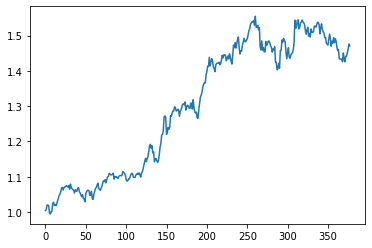

epoch :  20 time_idx :  0 loss_reg :  tensor(0.6841, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2106) precision :  tensor(0.5532) return_rate tensor(0.0035) com_return_rate tensor(1.0035)
epoch :  20 time_idx :  100 loss_reg :  tensor(0.7043, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.1237) precision :  tensor(0.2203) return_rate tensor(-0.0099) com_return_rate tensor(1.0851)
epoch :  20 time_idx :  200 loss_reg :  tensor(0.7021, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2830) precision :  tensor(0.8333) return_rate tensor(0.0064) com_return_rate tensor(1.3509)
epoch :  20 time_idx :  300 loss_reg :  tensor(0.6936, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0976) precision :  tensor(0.6571) return_rate tensor(0.0076) com_return_rate tensor(1.4066)


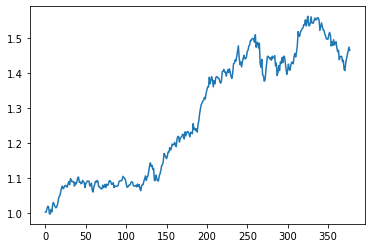

Epochs :  20 Iterations :  8148 Loss :  0.6929559931927121 ACC :  0.5222862502271982 MCC :  0.049305149879709805 Precision :  0.5293272160300889
epoch :  21 time_idx :  0 loss_reg :  tensor(0.6832, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.1979) precision :  tensor(0.5610) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  21 time_idx :  100 loss_reg :  tensor(0.7039, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(0.1993) precision :  tensor(0.2414) return_rate tensor(-0.0070) com_return_rate tensor(1.1140)
epoch :  21 time_idx :  200 loss_reg :  tensor(0.7033, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2697) precision :  tensor(0.8400) return_rate tensor(0.0073) com_return_rate tensor(1.2808)
epoch :  21 time_idx :  300 loss_reg :  tensor(0.6916, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1464) precision :  tensor(0.6857) return_rate tensor(0.0089) com_return_rate tensor(1.3843)


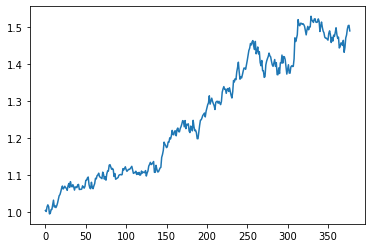

epoch :  22 time_idx :  0 loss_reg :  tensor(0.6837, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1761) precision :  tensor(0.5476) return_rate tensor(0.0057) com_return_rate tensor(1.0057)
epoch :  22 time_idx :  100 loss_reg :  tensor(0.7044, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(0.1890) precision :  tensor(0.2373) return_rate tensor(-0.0088) com_return_rate tensor(1.1814)
epoch :  22 time_idx :  200 loss_reg :  tensor(0.7029, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.2632) precision :  tensor(0.8431) return_rate tensor(0.0063) com_return_rate tensor(1.3687)
epoch :  22 time_idx :  300 loss_reg :  tensor(0.6920, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1577) precision :  tensor(0.6970) return_rate tensor(0.0090) com_return_rate tensor(1.4264)


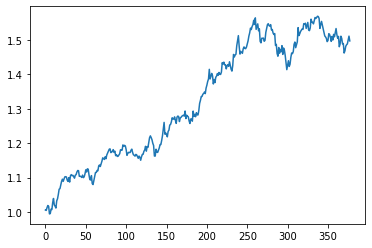

epoch :  23 time_idx :  0 loss_reg :  tensor(0.6851, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0035) com_return_rate tensor(1.0035)
epoch :  23 time_idx :  100 loss_reg :  tensor(0.7043, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(0.1787) precision :  tensor(0.2333) return_rate tensor(-0.0036) com_return_rate tensor(1.2090)
epoch :  23 time_idx :  200 loss_reg :  tensor(0.7014, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.2632) precision :  tensor(0.8431) return_rate tensor(0.0045) com_return_rate tensor(1.3955)
epoch :  23 time_idx :  300 loss_reg :  tensor(0.6909, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1577) precision :  tensor(0.6970) return_rate tensor(-0.0003) com_return_rate tensor(1.4136)


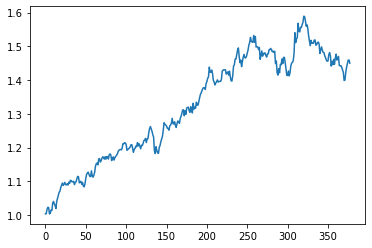

epoch :  24 time_idx :  0 loss_reg :  tensor(0.6828, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.2532) precision :  tensor(0.5778) return_rate tensor(-0.0086) com_return_rate tensor(0.9914)
epoch :  24 time_idx :  100 loss_reg :  tensor(0.7040, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.1683) precision :  tensor(0.2295) return_rate tensor(-0.0024) com_return_rate tensor(1.1316)
epoch :  24 time_idx :  200 loss_reg :  tensor(0.7005, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2830) precision :  tensor(0.8333) return_rate tensor(-0.0002) com_return_rate tensor(1.2757)
epoch :  24 time_idx :  300 loss_reg :  tensor(0.6916, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1464) precision :  tensor(0.6857) return_rate tensor(0.0076) com_return_rate tensor(1.3449)


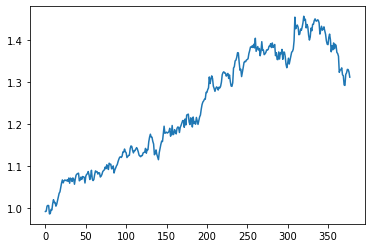

epoch :  25 time_idx :  0 loss_reg :  tensor(0.6824, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(-0.0055) com_return_rate tensor(0.9945)
epoch :  25 time_idx :  100 loss_reg :  tensor(0.7057, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(0.1578) precision :  tensor(0.2258) return_rate tensor(-0.0059) com_return_rate tensor(1.1320)
epoch :  25 time_idx :  200 loss_reg :  tensor(0.7036, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2697) precision :  tensor(0.8400) return_rate tensor(0.0064) com_return_rate tensor(1.2887)
epoch :  25 time_idx :  300 loss_reg :  tensor(0.6922, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.1197) precision :  tensor(0.6774) return_rate tensor(-0.0003) com_return_rate tensor(1.2869)


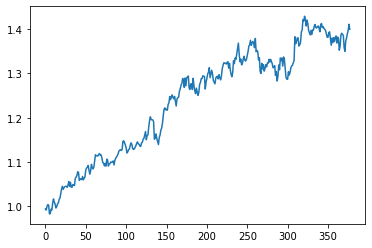

epoch :  26 time_idx :  0 loss_reg :  tensor(0.6842, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1761) precision :  tensor(0.5476) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  26 time_idx :  100 loss_reg :  tensor(0.7070, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(0.0584) precision :  tensor(0.2034) return_rate tensor(-0.0059) com_return_rate tensor(1.0987)
epoch :  26 time_idx :  200 loss_reg :  tensor(0.7010, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.2632) precision :  tensor(0.8431) return_rate tensor(0.0109) com_return_rate tensor(1.2405)
epoch :  26 time_idx :  300 loss_reg :  tensor(0.6917, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.1275) precision :  tensor(0.6765) return_rate tensor(-0.0003) com_return_rate tensor(1.2887)


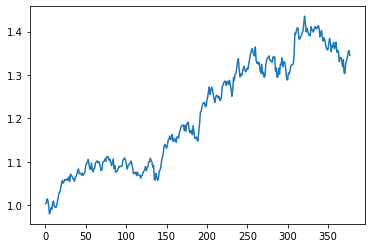

epoch :  27 time_idx :  0 loss_reg :  tensor(0.6851, grad_fn=<AddBackward0>) acc :  tensor(0.6471) mcc :  tensor(0.3005) precision :  tensor(0.6000) return_rate tensor(0.0002) com_return_rate tensor(1.0002)
epoch :  27 time_idx :  100 loss_reg :  tensor(0.7092, grad_fn=<AddBackward0>) acc :  tensor(0.3765) mcc :  tensor(0.0346) precision :  tensor(0.1967) return_rate tensor(-0.0059) com_return_rate tensor(1.1340)
epoch :  27 time_idx :  200 loss_reg :  tensor(0.7042, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.1878) precision :  tensor(0.8600) return_rate tensor(0.0047) com_return_rate tensor(1.3449)
epoch :  27 time_idx :  300 loss_reg :  tensor(0.6920, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(0.0591) precision :  tensor(0.6364) return_rate tensor(0.0076) com_return_rate tensor(1.4119)


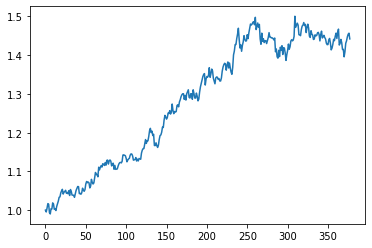

epoch :  28 time_idx :  0 loss_reg :  tensor(0.6843, grad_fn=<AddBackward0>) acc :  tensor(0.6353) mcc :  tensor(0.2706) precision :  tensor(0.5952) return_rate tensor(-0.0042) com_return_rate tensor(0.9958)
epoch :  28 time_idx :  100 loss_reg :  tensor(0.7088, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(0.0584) precision :  tensor(0.2034) return_rate tensor(-0.0059) com_return_rate tensor(1.0639)
epoch :  28 time_idx :  200 loss_reg :  tensor(0.7041, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0093) com_return_rate tensor(1.3210)
epoch :  28 time_idx :  300 loss_reg :  tensor(0.6927, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(0.0488) precision :  tensor(0.6286) return_rate tensor(-0.0003) com_return_rate tensor(1.3390)


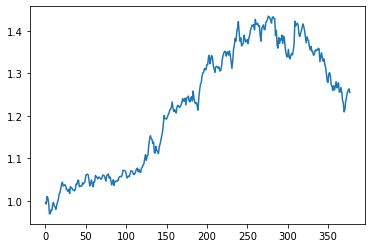

epoch :  29 time_idx :  0 loss_reg :  tensor(0.6838, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2319) precision :  tensor(0.5652) return_rate tensor(-0.0072) com_return_rate tensor(0.9928)
epoch :  29 time_idx :  100 loss_reg :  tensor(0.7078, grad_fn=<AddBackward0>) acc :  tensor(0.3882) mcc :  tensor(0.0901) precision :  tensor(0.2097) return_rate tensor(-0.0033) com_return_rate tensor(1.1150)
epoch :  29 time_idx :  200 loss_reg :  tensor(0.7024, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2763) precision :  tensor(0.8367) return_rate tensor(0.0057) com_return_rate tensor(1.3655)
epoch :  29 time_idx :  300 loss_reg :  tensor(0.6914, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1577) precision :  tensor(0.6970) return_rate tensor(0.0076) com_return_rate tensor(1.3557)


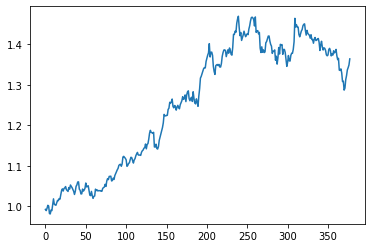

epoch :  30 time_idx :  0 loss_reg :  tensor(0.6851, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1894) precision :  tensor(0.5417) return_rate tensor(-0.0117) com_return_rate tensor(0.9883)
epoch :  30 time_idx :  100 loss_reg :  tensor(0.7080, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(0.1346) precision :  tensor(0.2241) return_rate tensor(-0.0059) com_return_rate tensor(1.1095)
epoch :  30 time_idx :  200 loss_reg :  tensor(0.7013, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2763) precision :  tensor(0.8367) return_rate tensor(0.0092) com_return_rate tensor(1.2830)
epoch :  30 time_idx :  300 loss_reg :  tensor(0.6919, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1464) precision :  tensor(0.6857) return_rate tensor(0.0020) com_return_rate tensor(1.3017)


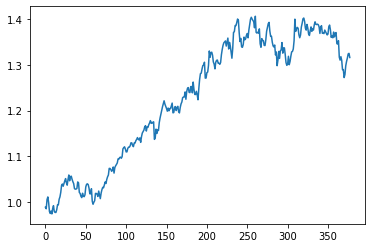

Epochs :  30 Iterations :  12028 Loss :  0.6930219220746424 ACC :  0.5208308225516806 MCC :  0.046512278703883886 Precision :  0.5282847950158199
epoch :  31 time_idx :  0 loss_reg :  tensor(0.6847, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.2581) precision :  tensor(0.5745) return_rate tensor(0.0005) com_return_rate tensor(1.0005)
epoch :  31 time_idx :  100 loss_reg :  tensor(0.7064, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(0.1127) precision :  tensor(0.2167) return_rate tensor(-0.0033) com_return_rate tensor(1.1710)
epoch :  31 time_idx :  200 loss_reg :  tensor(0.7017, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2830) precision :  tensor(0.8333) return_rate tensor(0.0093) com_return_rate tensor(1.3352)
epoch :  31 time_idx :  300 loss_reg :  tensor(0.6918, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(0.0294) precision :  tensor(0.6176) return_rate tensor(0.0035) com_return_rate tensor(1.3515)


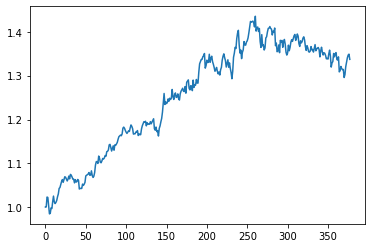

epoch :  32 time_idx :  0 loss_reg :  tensor(0.6868, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2059) precision :  tensor(0.5556) return_rate tensor(-0.0023) com_return_rate tensor(0.9977)
epoch :  32 time_idx :  100 loss_reg :  tensor(0.7077, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(0.1471) precision :  tensor(0.2222) return_rate tensor(-0.0033) com_return_rate tensor(1.1952)
epoch :  32 time_idx :  200 loss_reg :  tensor(0.6958, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.2632) precision :  tensor(0.8431) return_rate tensor(0.0106) com_return_rate tensor(1.3059)
epoch :  32 time_idx :  300 loss_reg :  tensor(0.6896, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2562) precision :  tensor(0.7576) return_rate tensor(0.0121) com_return_rate tensor(1.3881)


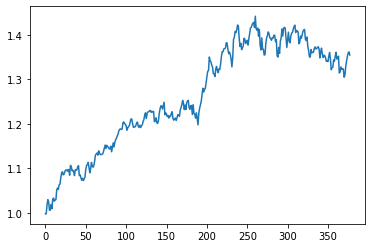

epoch :  33 time_idx :  0 loss_reg :  tensor(0.6874, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1845) precision :  tensor(0.5435) return_rate tensor(-0.0018) com_return_rate tensor(0.9982)
epoch :  33 time_idx :  100 loss_reg :  tensor(0.7057, grad_fn=<AddBackward0>) acc :  tensor(0.4235) mcc :  tensor(0.2158) precision :  tensor(0.2381) return_rate tensor(-0.0033) com_return_rate tensor(1.1657)
epoch :  33 time_idx :  200 loss_reg :  tensor(0.6996, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2763) precision :  tensor(0.8367) return_rate tensor(0.0073) com_return_rate tensor(1.2926)
epoch :  33 time_idx :  300 loss_reg :  tensor(0.6905, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.1063) precision :  tensor(0.6579) return_rate tensor(0.0128) com_return_rate tensor(1.2958)


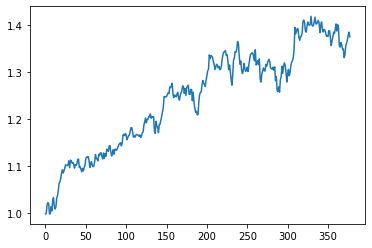

epoch :  34 time_idx :  0 loss_reg :  tensor(0.6882, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2017) precision :  tensor(0.5581) return_rate tensor(0.0014) com_return_rate tensor(1.0014)
epoch :  34 time_idx :  100 loss_reg :  tensor(0.7066, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(0.1578) precision :  tensor(0.2258) return_rate tensor(-0.0097) com_return_rate tensor(1.0752)
epoch :  34 time_idx :  200 loss_reg :  tensor(0.6981, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2088) precision :  tensor(0.8511) return_rate tensor(0.0106) com_return_rate tensor(1.2378)
epoch :  34 time_idx :  300 loss_reg :  tensor(0.6914, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0872) precision :  tensor(0.6486) return_rate tensor(0.0130) com_return_rate tensor(1.2631)


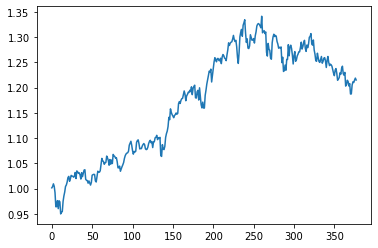

epoch :  35 time_idx :  0 loss_reg :  tensor(0.6896, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.0988) precision :  tensor(0.5000) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  35 time_idx :  100 loss_reg :  tensor(0.7075, grad_fn=<AddBackward0>) acc :  tensor(0.3765) mcc :  tensor(0.0346) precision :  tensor(0.1967) return_rate tensor(-0.0164) com_return_rate tensor(1.2257)
epoch :  35 time_idx :  200 loss_reg :  tensor(0.6989, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0064) com_return_rate tensor(1.3196)
epoch :  35 time_idx :  300 loss_reg :  tensor(0.6910, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0976) precision :  tensor(0.6571) return_rate tensor(0.0038) com_return_rate tensor(1.2707)


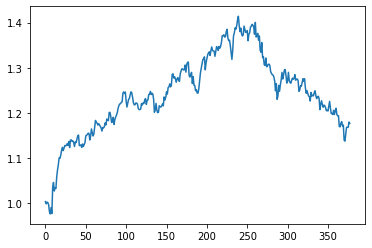

epoch :  36 time_idx :  0 loss_reg :  tensor(0.6906, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0424) precision :  tensor(0.4783) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  36 time_idx :  100 loss_reg :  tensor(0.7087, grad_fn=<AddBackward0>) acc :  tensor(0.3647) mcc :  tensor(0.0223) precision :  tensor(0.1935) return_rate tensor(-0.0166) com_return_rate tensor(1.0882)
epoch :  36 time_idx :  200 loss_reg :  tensor(0.6978, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2088) precision :  tensor(0.8511) return_rate tensor(0.0125) com_return_rate tensor(1.1833)
epoch :  36 time_idx :  300 loss_reg :  tensor(0.6914, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0784) precision :  tensor(0.6471) return_rate tensor(0.0099) com_return_rate tensor(1.2239)


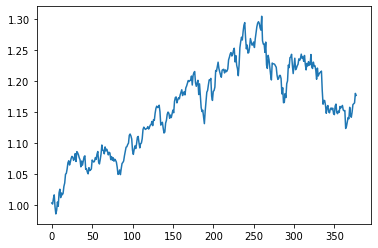

epoch :  37 time_idx :  0 loss_reg :  tensor(0.6868, grad_fn=<AddBackward0>) acc :  tensor(0.5765) mcc :  tensor(0.1586) precision :  tensor(0.5333) return_rate tensor(-0.0027) com_return_rate tensor(0.9973)
epoch :  37 time_idx :  100 loss_reg :  tensor(0.7120, grad_fn=<AddBackward0>) acc :  tensor(0.3529) mcc :  tensor(0.1023) precision :  tensor(0.2090) return_rate tensor(-0.0069) com_return_rate tensor(1.1106)
epoch :  37 time_idx :  200 loss_reg :  tensor(0.6988, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(-0.2380) precision :  tensor(0.8372) return_rate tensor(0.0043) com_return_rate tensor(1.1749)
epoch :  37 time_idx :  300 loss_reg :  tensor(0.6898, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.1275) precision :  tensor(0.6765) return_rate tensor(0.0090) com_return_rate tensor(1.3070)


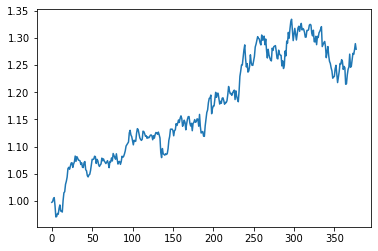

epoch :  38 time_idx :  0 loss_reg :  tensor(0.6880, grad_fn=<AddBackward0>) acc :  tensor(0.5765) mcc :  tensor(0.1544) precision :  tensor(0.5349) return_rate tensor(0.0025) com_return_rate tensor(1.0025)
epoch :  38 time_idx :  100 loss_reg :  tensor(0.7104, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(0.1962) precision :  tensor(0.2308) return_rate tensor(-0.0276) com_return_rate tensor(1.1252)
epoch :  38 time_idx :  200 loss_reg :  tensor(0.6997, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(-0.2232) precision :  tensor(0.8444) return_rate tensor(0.0043) com_return_rate tensor(1.2563)
epoch :  38 time_idx :  300 loss_reg :  tensor(0.6897, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1356) precision :  tensor(0.6757) return_rate tensor(0.0090) com_return_rate tensor(1.3249)


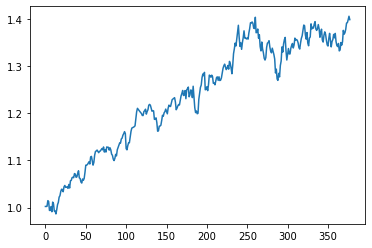

epoch :  39 time_idx :  0 loss_reg :  tensor(0.6897, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0600) precision :  tensor(0.4884) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  39 time_idx :  100 loss_reg :  tensor(0.7113, grad_fn=<AddBackward0>) acc :  tensor(0.3882) mcc :  tensor(0.1861) precision :  tensor(0.2273) return_rate tensor(-0.0141) com_return_rate tensor(1.1427)
epoch :  39 time_idx :  200 loss_reg :  tensor(0.7006, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0043) com_return_rate tensor(1.2437)
epoch :  39 time_idx :  300 loss_reg :  tensor(0.6899, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1464) precision :  tensor(0.6857) return_rate tensor(0.0090) com_return_rate tensor(1.2215)


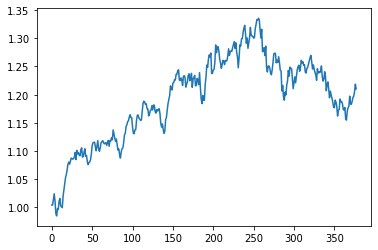

epoch :  40 time_idx :  0 loss_reg :  tensor(0.6878, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1289) precision :  tensor(0.5238) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  40 time_idx :  100 loss_reg :  tensor(0.7086, grad_fn=<AddBackward0>) acc :  tensor(0.4000) mcc :  tensor(0.1962) precision :  tensor(0.2308) return_rate tensor(-0.0141) com_return_rate tensor(1.0674)
epoch :  40 time_idx :  200 loss_reg :  tensor(0.6994, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(-0.2898) precision :  tensor(0.8298) return_rate tensor(0.0117) com_return_rate tensor(1.2223)
epoch :  40 time_idx :  300 loss_reg :  tensor(0.6918, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0771) precision :  tensor(0.6410) return_rate tensor(0.0099) com_return_rate tensor(1.2733)


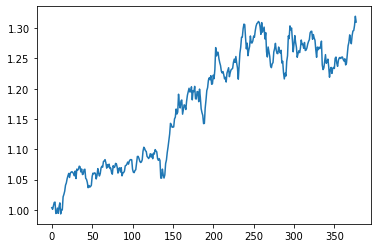

Epochs :  40 Iterations :  15908 Loss :  0.6934346232524852 ACC :  0.5122195421958092 MCC :  0.0348042492075468 Precision :  0.5230513626215115
epoch :  41 time_idx :  0 loss_reg :  tensor(0.6881, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1289) precision :  tensor(0.5238) return_rate tensor(0.0035) com_return_rate tensor(1.0035)
epoch :  41 time_idx :  100 loss_reg :  tensor(0.7080, grad_fn=<AddBackward0>) acc :  tensor(0.3882) mcc :  tensor(0.1861) precision :  tensor(0.2273) return_rate tensor(-0.0141) com_return_rate tensor(1.1713)
epoch :  41 time_idx :  200 loss_reg :  tensor(0.6995, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0100) com_return_rate tensor(1.3005)
epoch :  41 time_idx :  300 loss_reg :  tensor(0.6939, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.0096) precision :  tensor(0.5952) return_rate tensor(0.0137) com_return_rate tensor(1.2554)


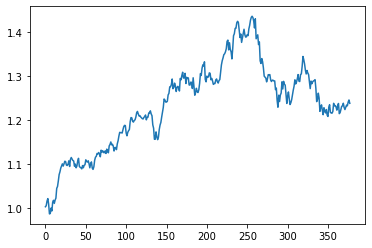

epoch :  42 time_idx :  0 loss_reg :  tensor(0.6879, grad_fn=<AddBackward0>) acc :  tensor(0.5765) mcc :  tensor(0.1440) precision :  tensor(0.5405) return_rate tensor(0.0038) com_return_rate tensor(1.0038)
epoch :  42 time_idx :  100 loss_reg :  tensor(0.7106, grad_fn=<AddBackward0>) acc :  tensor(0.3765) mcc :  tensor(0.1759) precision :  tensor(0.2239) return_rate tensor(-0.0067) com_return_rate tensor(1.1237)
epoch :  42 time_idx :  200 loss_reg :  tensor(0.7009, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(-0.3186) precision :  tensor(0.8140) return_rate tensor(0.0065) com_return_rate tensor(1.1775)
epoch :  42 time_idx :  300 loss_reg :  tensor(0.6933, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(-0.0299) precision :  tensor(0.5806) return_rate tensor(-0.0057) com_return_rate tensor(1.2019)


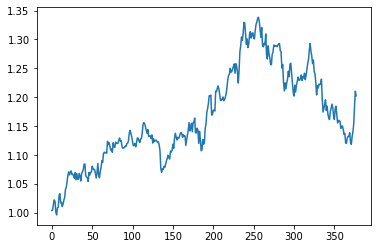

epoch :  43 time_idx :  0 loss_reg :  tensor(0.6910, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(0.0167) precision :  tensor(0.4667) return_rate tensor(0.0021) com_return_rate tensor(1.0021)
epoch :  43 time_idx :  100 loss_reg :  tensor(0.7133, grad_fn=<AddBackward0>) acc :  tensor(0.3412) mcc :  tensor(0.1440) precision :  tensor(0.2143) return_rate tensor(-0.0045) com_return_rate tensor(1.0981)
epoch :  43 time_idx :  200 loss_reg :  tensor(0.7005, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2830) precision :  tensor(0.8333) return_rate tensor(0.0043) com_return_rate tensor(1.2560)
epoch :  43 time_idx :  300 loss_reg :  tensor(0.6946, grad_fn=<AddBackward0>) acc :  tensor(0.4353) mcc :  tensor(-0.0798) precision :  tensor(0.5484) return_rate tensor(0.0013) com_return_rate tensor(1.2067)


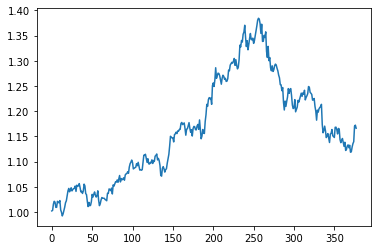

epoch :  44 time_idx :  0 loss_reg :  tensor(0.6905, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0465) precision :  tensor(0.4792) return_rate tensor(0.0020) com_return_rate tensor(1.0020)
epoch :  44 time_idx :  100 loss_reg :  tensor(0.7154, grad_fn=<AddBackward0>) acc :  tensor(0.3647) mcc :  tensor(0.1655) precision :  tensor(0.2206) return_rate tensor(-0.0035) com_return_rate tensor(1.1398)
epoch :  44 time_idx :  200 loss_reg :  tensor(0.6982, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0079) com_return_rate tensor(1.2658)
epoch :  44 time_idx :  300 loss_reg :  tensor(0.6944, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.0595) precision :  tensor(0.5625) return_rate tensor(0.0031) com_return_rate tensor(1.2174)


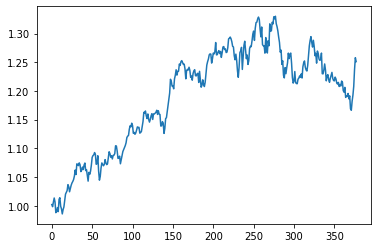

epoch :  45 time_idx :  0 loss_reg :  tensor(0.6902, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(0.0028) precision :  tensor(0.4600) return_rate tensor(-0.0028) com_return_rate tensor(0.9972)
epoch :  45 time_idx :  100 loss_reg :  tensor(0.7136, grad_fn=<AddBackward0>) acc :  tensor(0.3529) mcc :  tensor(0.1549) precision :  tensor(0.2174) return_rate tensor(-0.0057) com_return_rate tensor(1.2071)
epoch :  45 time_idx :  200 loss_reg :  tensor(0.7005, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0079) com_return_rate tensor(1.4196)
epoch :  45 time_idx :  300 loss_reg :  tensor(0.6949, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(0.0730) precision :  tensor(0.6538) return_rate tensor(-0.0005) com_return_rate tensor(1.4173)


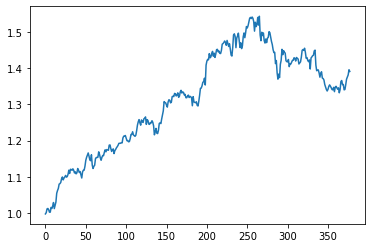

epoch :  46 time_idx :  0 loss_reg :  tensor(0.6909, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0600) precision :  tensor(0.4884) return_rate tensor(0.0024) com_return_rate tensor(1.0024)
epoch :  46 time_idx :  100 loss_reg :  tensor(0.7166, grad_fn=<AddBackward0>) acc :  tensor(0.3176) mcc :  tensor(0.1210) precision :  tensor(0.2083) return_rate tensor(-0.0099) com_return_rate tensor(1.0770)
epoch :  46 time_idx :  200 loss_reg :  tensor(0.6976, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0079) com_return_rate tensor(1.2086)
epoch :  46 time_idx :  300 loss_reg :  tensor(0.6916, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2512) precision :  tensor(0.7368) return_rate tensor(0.0034) com_return_rate tensor(1.2054)


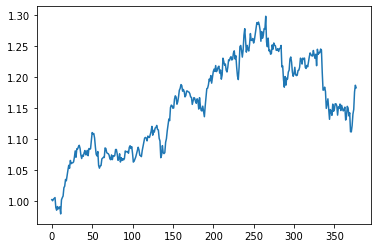

epoch :  47 time_idx :  0 loss_reg :  tensor(0.6926, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0424) precision :  tensor(0.4783) return_rate tensor(0.0093) com_return_rate tensor(1.0093)
epoch :  47 time_idx :  100 loss_reg :  tensor(0.7170, grad_fn=<AddBackward0>) acc :  tensor(0.3176) mcc :  tensor(0.1210) precision :  tensor(0.2083) return_rate tensor(-0.0036) com_return_rate tensor(1.1303)
epoch :  47 time_idx :  200 loss_reg :  tensor(0.6968, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0125) com_return_rate tensor(1.2814)
epoch :  47 time_idx :  300 loss_reg :  tensor(0.6929, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0784) precision :  tensor(0.6471) return_rate tensor(-0.0007) com_return_rate tensor(1.3050)


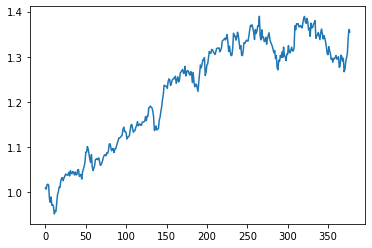

epoch :  48 time_idx :  0 loss_reg :  tensor(0.6931, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(0.0089) precision :  tensor(0.4634) return_rate tensor(-0.0009) com_return_rate tensor(0.9991)
epoch :  48 time_idx :  100 loss_reg :  tensor(0.7180, grad_fn=<AddBackward0>) acc :  tensor(0.3059) mcc :  tensor(0.1758) precision :  tensor(0.2133) return_rate tensor(-0.0049) com_return_rate tensor(1.1434)
epoch :  48 time_idx :  200 loss_reg :  tensor(0.6977, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.1878) precision :  tensor(0.8600) return_rate tensor(0.0025) com_return_rate tensor(1.1960)
epoch :  48 time_idx :  300 loss_reg :  tensor(0.6916, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2029) precision :  tensor(0.7105) return_rate tensor(-0.0005) com_return_rate tensor(1.0896)


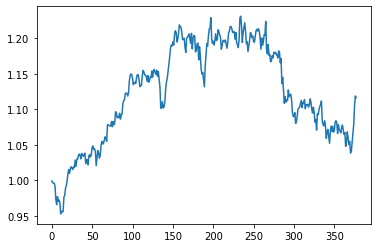

epoch :  49 time_idx :  0 loss_reg :  tensor(0.6915, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0306) precision :  tensor(0.4750) return_rate tensor(0.0093) com_return_rate tensor(1.0093)
epoch :  49 time_idx :  100 loss_reg :  tensor(0.7177, grad_fn=<AddBackward0>) acc :  tensor(0.3059) mcc :  tensor(0.1088) precision :  tensor(0.2055) return_rate tensor(-0.0057) com_return_rate tensor(1.0694)
epoch :  49 time_idx :  200 loss_reg :  tensor(0.6991, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0125) com_return_rate tensor(1.1890)
epoch :  49 time_idx :  300 loss_reg :  tensor(0.6917, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.2699) precision :  tensor(0.7436) return_rate tensor(0.0028) com_return_rate tensor(1.1550)


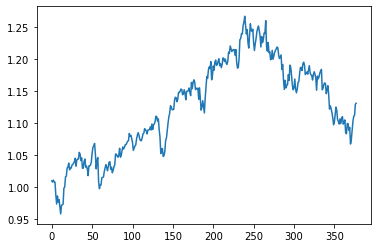

epoch :  50 time_idx :  0 loss_reg :  tensor(0.6905, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0384) precision :  tensor(0.4773) return_rate tensor(0.0073) com_return_rate tensor(1.0073)
epoch :  50 time_idx :  100 loss_reg :  tensor(0.7169, grad_fn=<AddBackward0>) acc :  tensor(0.3176) mcc :  tensor(0.1210) precision :  tensor(0.2083) return_rate tensor(-0.0023) com_return_rate tensor(1.2835)
epoch :  50 time_idx :  200 loss_reg :  tensor(0.6963, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(-0.1741) precision :  tensor(0.8654) return_rate tensor(0.0125) com_return_rate tensor(1.5774)
epoch :  50 time_idx :  300 loss_reg :  tensor(0.6906, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1825) precision :  tensor(0.6905) return_rate tensor(0.0079) com_return_rate tensor(1.5424)


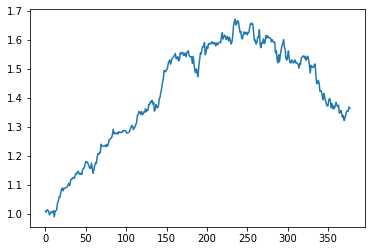

Epochs :  50 Iterations :  19788 Loss :  0.6937954928149882 ACC :  0.510430579179341 MCC :  0.0354163231839397 Precision :  0.5217259943523666
epoch :  51 time_idx :  0 loss_reg :  tensor(0.6933, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0640) precision :  tensor(0.4889) return_rate tensor(0.0064) com_return_rate tensor(1.0064)
epoch :  51 time_idx :  100 loss_reg :  tensor(0.7166, grad_fn=<AddBackward0>) acc :  tensor(0.3294) mcc :  tensor(0.1327) precision :  tensor(0.2113) return_rate tensor(-0.0106) com_return_rate tensor(1.1847)
epoch :  51 time_idx :  200 loss_reg :  tensor(0.6961, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(-0.1741) precision :  tensor(0.8654) return_rate tensor(0.0229) com_return_rate tensor(1.2662)
epoch :  51 time_idx :  300 loss_reg :  tensor(0.6889, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2325) precision :  tensor(0.7297) return_rate tensor(0.0073) com_return_rate tensor(1.2257)


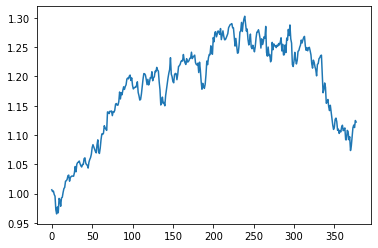

epoch :  52 time_idx :  0 loss_reg :  tensor(0.6901, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1252) precision :  tensor(0.5250) return_rate tensor(0.0022) com_return_rate tensor(1.0022)
epoch :  52 time_idx :  100 loss_reg :  tensor(0.7199, grad_fn=<AddBackward0>) acc :  tensor(0.2706) mcc :  tensor(0.1443) precision :  tensor(0.2051) return_rate tensor(-0.0175) com_return_rate tensor(1.0463)
epoch :  52 time_idx :  200 loss_reg :  tensor(0.6950, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(-0.1809) precision :  tensor(0.8627) return_rate tensor(0.0126) com_return_rate tensor(1.1427)
epoch :  52 time_idx :  300 loss_reg :  tensor(0.6869, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2512) precision :  tensor(0.7368) return_rate tensor(0.0109) com_return_rate tensor(1.0847)


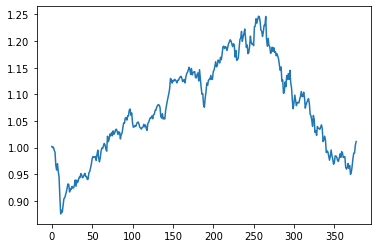

epoch :  53 time_idx :  0 loss_reg :  tensor(0.6928, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0230) precision :  tensor(0.4722) return_rate tensor(0.0031) com_return_rate tensor(1.0031)
epoch :  53 time_idx :  100 loss_reg :  tensor(0.7162, grad_fn=<AddBackward0>) acc :  tensor(0.3176) mcc :  tensor(0.1857) precision :  tensor(0.2162) return_rate tensor(-0.0023) com_return_rate tensor(1.0378)
epoch :  53 time_idx :  200 loss_reg :  tensor(0.6962, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2017) precision :  tensor(0.8542) return_rate tensor(0.0138) com_return_rate tensor(1.2313)
epoch :  53 time_idx :  300 loss_reg :  tensor(0.6857, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.1639) precision :  tensor(0.6739) return_rate tensor(0.0085) com_return_rate tensor(1.3183)


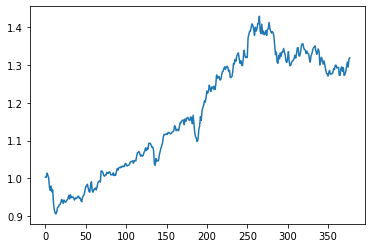

epoch :  54 time_idx :  0 loss_reg :  tensor(0.6932, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0964) precision :  tensor(0.5135) return_rate tensor(0.0031) com_return_rate tensor(1.0031)
epoch :  54 time_idx :  100 loss_reg :  tensor(0.7183, grad_fn=<AddBackward0>) acc :  tensor(0.2824) mcc :  tensor(0.1552) precision :  tensor(0.2078) return_rate tensor(-0.0086) com_return_rate tensor(1.0548)
epoch :  54 time_idx :  200 loss_reg :  tensor(0.6974, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0066) com_return_rate tensor(1.2150)
epoch :  54 time_idx :  300 loss_reg :  tensor(0.6866, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.2928) precision :  tensor(0.7714) return_rate tensor(0.0084) com_return_rate tensor(1.2168)


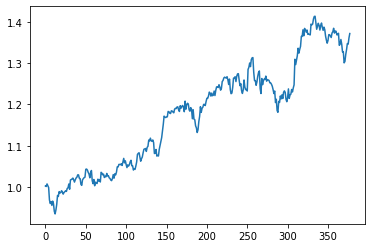

epoch :  55 time_idx :  0 loss_reg :  tensor(0.6938, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.0110) precision :  tensor(0.4516) return_rate tensor(0.0031) com_return_rate tensor(1.0031)
epoch :  55 time_idx :  100 loss_reg :  tensor(0.7175, grad_fn=<AddBackward0>) acc :  tensor(0.2471) mcc :  tensor(0.1204) precision :  tensor(0.2000) return_rate tensor(-0.0064) com_return_rate tensor(1.1392)
epoch :  55 time_idx :  200 loss_reg :  tensor(0.6961, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0170) com_return_rate tensor(1.2878)
epoch :  55 time_idx :  300 loss_reg :  tensor(0.6853, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2325) precision :  tensor(0.7297) return_rate tensor(0.0083) com_return_rate tensor(1.2809)


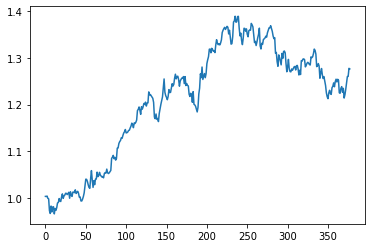

epoch :  56 time_idx :  0 loss_reg :  tensor(0.6925, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0230) precision :  tensor(0.4722) return_rate tensor(-0.0006) com_return_rate tensor(0.9994)
epoch :  56 time_idx :  100 loss_reg :  tensor(0.7157, grad_fn=<AddBackward0>) acc :  tensor(0.2706) mcc :  tensor(0.1443) precision :  tensor(0.2051) return_rate tensor(-0.0038) com_return_rate tensor(1.1220)
epoch :  56 time_idx :  200 loss_reg :  tensor(0.6974, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2017) precision :  tensor(0.8542) return_rate tensor(0.0044) com_return_rate tensor(1.2901)
epoch :  56 time_idx :  300 loss_reg :  tensor(0.6878, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1577) precision :  tensor(0.6970) return_rate tensor(0.0094) com_return_rate tensor(1.4463)


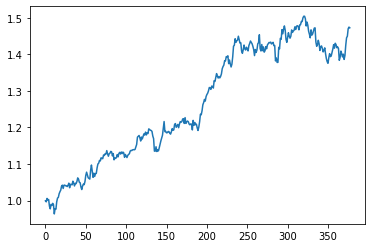

epoch :  57 time_idx :  0 loss_reg :  tensor(0.6929, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0381) precision :  tensor(0.4839) return_rate tensor(0.0010) com_return_rate tensor(1.0010)
epoch :  57 time_idx :  100 loss_reg :  tensor(0.7159, grad_fn=<AddBackward0>) acc :  tensor(0.2471) mcc :  tensor(0.1204) precision :  tensor(0.2000) return_rate tensor(-0.0117) com_return_rate tensor(1.0902)
epoch :  57 time_idx :  200 loss_reg :  tensor(0.6972, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.1878) precision :  tensor(0.8600) return_rate tensor(0.0031) com_return_rate tensor(1.1639)
epoch :  57 time_idx :  300 loss_reg :  tensor(0.6867, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0872) precision :  tensor(0.6486) return_rate tensor(0.0104) com_return_rate tensor(1.2181)


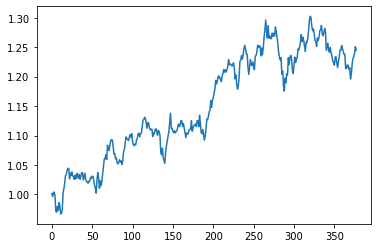

epoch :  58 time_idx :  0 loss_reg :  tensor(0.6924, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.0289) precision :  tensor(0.4412) return_rate tensor(0.0019) com_return_rate tensor(1.0019)
epoch :  58 time_idx :  100 loss_reg :  tensor(0.7180, grad_fn=<AddBackward0>) acc :  tensor(0.2118) mcc :  tensor(0.0748) precision :  tensor(0.1928) return_rate tensor(-0.0099) com_return_rate tensor(1.1579)
epoch :  58 time_idx :  200 loss_reg :  tensor(0.7004, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2017) precision :  tensor(0.8542) return_rate tensor(0.0004) com_return_rate tensor(1.3874)
epoch :  58 time_idx :  300 loss_reg :  tensor(0.6881, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2255) precision :  tensor(0.7353) return_rate tensor(0.0107) com_return_rate tensor(1.5767)


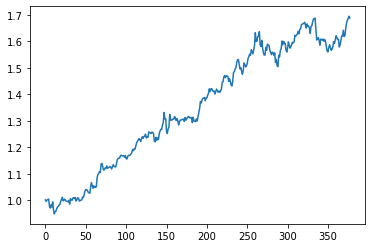

epoch :  59 time_idx :  0 loss_reg :  tensor(0.6923, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0553) precision :  tensor(0.4242) return_rate tensor(0.0019) com_return_rate tensor(1.0019)
epoch :  59 time_idx :  100 loss_reg :  tensor(0.7196, grad_fn=<AddBackward0>) acc :  tensor(0.2235) mcc :  tensor(0.0921) precision :  tensor(0.1951) return_rate tensor(-0.0107) com_return_rate tensor(1.0907)
epoch :  59 time_idx :  200 loss_reg :  tensor(0.7027, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0031) com_return_rate tensor(1.2821)
epoch :  59 time_idx :  300 loss_reg :  tensor(0.6883, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2694) precision :  tensor(0.7742) return_rate tensor(0.0042) com_return_rate tensor(1.1984)


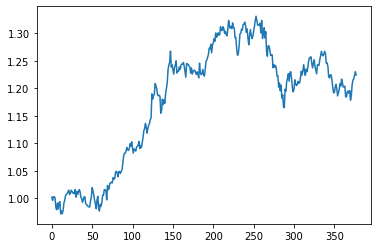

epoch :  60 time_idx :  0 loss_reg :  tensor(0.6930, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.0682) precision :  tensor(0.4211) return_rate tensor(0.0067) com_return_rate tensor(1.0067)
epoch :  60 time_idx :  100 loss_reg :  tensor(0.7215, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0123) com_return_rate tensor(1.1407)
epoch :  60 time_idx :  200 loss_reg :  tensor(0.6994, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2017) precision :  tensor(0.8542) return_rate tensor(0.0079) com_return_rate tensor(1.3662)
epoch :  60 time_idx :  300 loss_reg :  tensor(0.6913, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2379) precision :  tensor(0.7500) return_rate tensor(0.0094) com_return_rate tensor(1.3549)


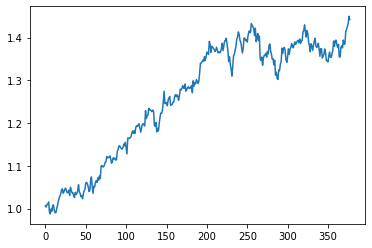

Epochs :  60 Iterations :  23668 Loss :  0.6938621348019728 ACC :  0.5122195424454421 MCC :  nan Precision :  0.523069629392865
epoch :  61 time_idx :  0 loss_reg :  tensor(0.6928, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.0333) precision :  tensor(0.4375) return_rate tensor(-0.0002) com_return_rate tensor(0.9998)
epoch :  61 time_idx :  100 loss_reg :  tensor(0.7200, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0094) com_return_rate tensor(1.1063)
epoch :  61 time_idx :  200 loss_reg :  tensor(0.7013, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2017) precision :  tensor(0.8542) return_rate tensor(0.0063) com_return_rate tensor(1.2846)
epoch :  61 time_idx :  300 loss_reg :  tensor(0.6899, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2138) precision :  tensor(0.7222) return_rate tensor(0.0091) com_return_rate tensor(1.3232)


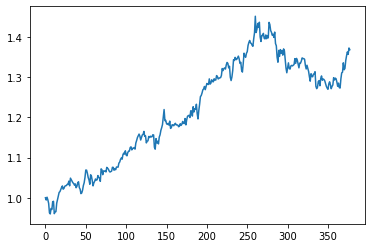

epoch :  62 time_idx :  0 loss_reg :  tensor(0.6927, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0508) precision :  tensor(0.4286) return_rate tensor(0.0089) com_return_rate tensor(1.0089)
epoch :  62 time_idx :  100 loss_reg :  tensor(0.7185, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0061) com_return_rate tensor(1.1061)
epoch :  62 time_idx :  200 loss_reg :  tensor(0.7011, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0106) com_return_rate tensor(1.2719)
epoch :  62 time_idx :  300 loss_reg :  tensor(0.6901, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2745) precision :  tensor(0.7647) return_rate tensor(0.0038) com_return_rate tensor(1.2367)


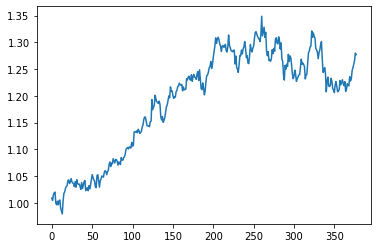

epoch :  63 time_idx :  0 loss_reg :  tensor(0.6919, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0384) precision :  tensor(0.4390) return_rate tensor(0.0059) com_return_rate tensor(1.0059)
epoch :  63 time_idx :  100 loss_reg :  tensor(0.7187, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0118) com_return_rate tensor(1.1150)
epoch :  63 time_idx :  200 loss_reg :  tensor(0.7001, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2088) precision :  tensor(0.8511) return_rate tensor(0.0091) com_return_rate tensor(1.2692)
epoch :  63 time_idx :  300 loss_reg :  tensor(0.6898, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2745) precision :  tensor(0.7647) return_rate tensor(0.0054) com_return_rate tensor(1.4284)


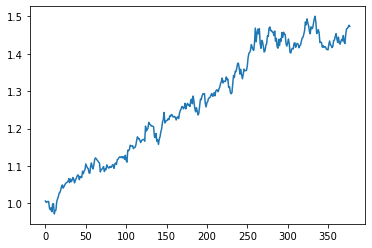

epoch :  64 time_idx :  0 loss_reg :  tensor(0.6929, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0424) precision :  tensor(0.4359) return_rate tensor(0.0040) com_return_rate tensor(1.0040)
epoch :  64 time_idx :  100 loss_reg :  tensor(0.7185, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0063) com_return_rate tensor(1.1299)
epoch :  64 time_idx :  200 loss_reg :  tensor(0.6980, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(-0.1673) precision :  tensor(0.8679) return_rate tensor(0.0036) com_return_rate tensor(1.3111)
epoch :  64 time_idx :  300 loss_reg :  tensor(0.6921, grad_fn=<AddBackward0>) acc :  tensor(0.5765) mcc :  tensor(0.2195) precision :  tensor(0.7419) return_rate tensor(0.0033) com_return_rate tensor(1.4955)


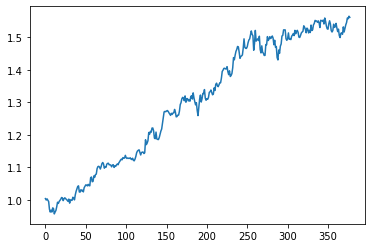

epoch :  65 time_idx :  0 loss_reg :  tensor(0.6926, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0384) precision :  tensor(0.4390) return_rate tensor(0.0069) com_return_rate tensor(1.0069)
epoch :  65 time_idx :  100 loss_reg :  tensor(0.7190, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0062) com_return_rate tensor(1.1290)
epoch :  65 time_idx :  200 loss_reg :  tensor(0.6986, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(-0.1809) precision :  tensor(0.8627) return_rate tensor(0.0111) com_return_rate tensor(1.3995)
epoch :  65 time_idx :  300 loss_reg :  tensor(0.6895, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2562) precision :  tensor(0.7576) return_rate tensor(0.0033) com_return_rate tensor(1.4414)


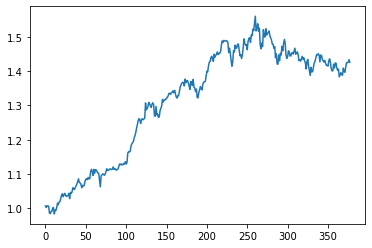

epoch :  66 time_idx :  0 loss_reg :  tensor(0.6924, grad_fn=<AddBackward0>) acc :  tensor(0.4588) mcc :  tensor(-0.0897) precision :  tensor(0.4103) return_rate tensor(0.0031) com_return_rate tensor(1.0031)
epoch :  66 time_idx :  100 loss_reg :  tensor(0.7194, grad_fn=<AddBackward0>) acc :  tensor(0.2118) mcc :  tensor(0.0748) precision :  tensor(0.1928) return_rate tensor(-0.0061) com_return_rate tensor(1.1098)
epoch :  66 time_idx :  200 loss_reg :  tensor(0.6995, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0075) com_return_rate tensor(1.2957)
epoch :  66 time_idx :  300 loss_reg :  tensor(0.6901, grad_fn=<AddBackward0>) acc :  tensor(0.5765) mcc :  tensor(0.1952) precision :  tensor(0.7143) return_rate tensor(0.0039) com_return_rate tensor(1.3900)


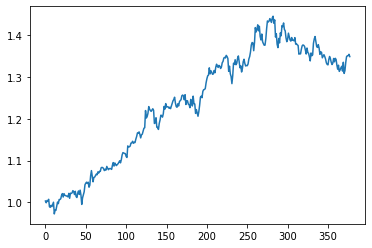

epoch :  67 time_idx :  0 loss_reg :  tensor(0.6918, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.0207) precision :  tensor(0.4474) return_rate tensor(0.0029) com_return_rate tensor(1.0029)
epoch :  67 time_idx :  100 loss_reg :  tensor(0.7200, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0034) com_return_rate tensor(1.1292)
epoch :  67 time_idx :  200 loss_reg :  tensor(0.6982, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(-0.1809) precision :  tensor(0.8627) return_rate tensor(0.0111) com_return_rate tensor(1.2373)
epoch :  67 time_idx :  300 loss_reg :  tensor(0.6909, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2875) precision :  tensor(0.7812) return_rate tensor(0.0053) com_return_rate tensor(1.2157)


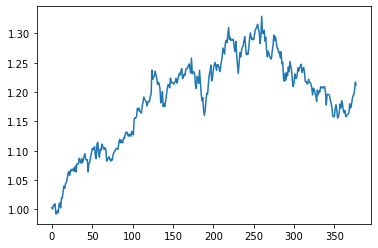

epoch :  68 time_idx :  0 loss_reg :  tensor(0.6924, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.0167) precision :  tensor(0.4500) return_rate tensor(0.0031) com_return_rate tensor(1.0031)
epoch :  68 time_idx :  100 loss_reg :  tensor(0.7184, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0061) com_return_rate tensor(1.1810)
epoch :  68 time_idx :  200 loss_reg :  tensor(0.6993, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.1878) precision :  tensor(0.8600) return_rate tensor(0.0111) com_return_rate tensor(1.3596)
epoch :  68 time_idx :  300 loss_reg :  tensor(0.6912, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.3055) precision :  tensor(0.7879) return_rate tensor(0.0020) com_return_rate tensor(1.4931)


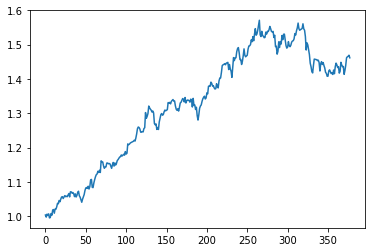

epoch :  69 time_idx :  0 loss_reg :  tensor(0.6910, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0508) precision :  tensor(0.4286) return_rate tensor(0.0077) com_return_rate tensor(1.0077)
epoch :  69 time_idx :  100 loss_reg :  tensor(0.7203, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0044) com_return_rate tensor(1.1826)
epoch :  69 time_idx :  200 loss_reg :  tensor(0.6995, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.1351) precision :  tensor(0.8696) return_rate tensor(0.0196) com_return_rate tensor(1.3887)
epoch :  69 time_idx :  300 loss_reg :  tensor(0.6883, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2379) precision :  tensor(0.7500) return_rate tensor(0.0089) com_return_rate tensor(1.4471)


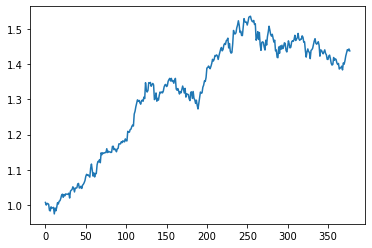

epoch :  70 time_idx :  0 loss_reg :  tensor(0.6902, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0268) precision :  tensor(0.4737) return_rate tensor(0.0024) com_return_rate tensor(1.0024)
epoch :  70 time_idx :  100 loss_reg :  tensor(0.7220, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0118) com_return_rate tensor(1.1360)
epoch :  70 time_idx :  200 loss_reg :  tensor(0.6986, grad_fn=<AddBackward0>) acc :  tensor(0.4941) mcc :  tensor(-0.2017) precision :  tensor(0.8542) return_rate tensor(0.0167) com_return_rate tensor(1.3323)
epoch :  70 time_idx :  300 loss_reg :  tensor(0.6890, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.3055) precision :  tensor(0.7879) return_rate tensor(0.0032) com_return_rate tensor(1.2691)


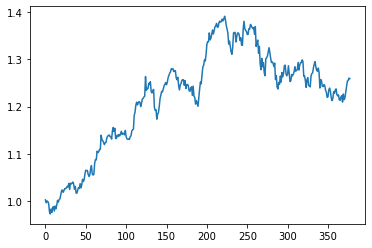

Epochs :  70 Iterations :  27548 Loss :  0.6940213406516105 ACC :  0.5102183297468522 MCC :  nan Precision :  0.522132112524597
epoch :  71 time_idx :  0 loss_reg :  tensor(0.6899, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.1034) precision :  tensor(0.5122) return_rate tensor(0.0029) com_return_rate tensor(1.0029)
epoch :  71 time_idx :  100 loss_reg :  tensor(0.7209, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0050) com_return_rate tensor(1.0832)
epoch :  71 time_idx :  200 loss_reg :  tensor(0.7004, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.1425) precision :  tensor(0.8667) return_rate tensor(0.0134) com_return_rate tensor(1.1664)
epoch :  71 time_idx :  300 loss_reg :  tensor(0.6880, grad_fn=<AddBackward0>) acc :  tensor(0.6353) mcc :  tensor(0.3370) precision :  tensor(0.8125) return_rate tensor(0.0030) com_return_rate tensor(1.1433)


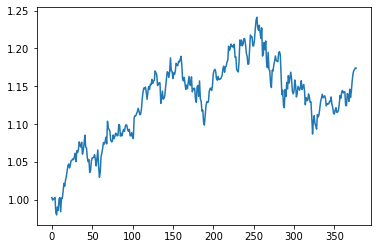

epoch :  72 time_idx :  0 loss_reg :  tensor(0.6895, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(0.0089) precision :  tensor(0.4634) return_rate tensor(0.0046) com_return_rate tensor(1.0046)
epoch :  72 time_idx :  100 loss_reg :  tensor(0.7191, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0026) com_return_rate tensor(1.0183)
epoch :  72 time_idx :  200 loss_reg :  tensor(0.6996, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2088) precision :  tensor(0.8511) return_rate tensor(0.0061) com_return_rate tensor(1.1488)
epoch :  72 time_idx :  300 loss_reg :  tensor(0.6883, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2694) precision :  tensor(0.7742) return_rate tensor(0.0062) com_return_rate tensor(1.1912)


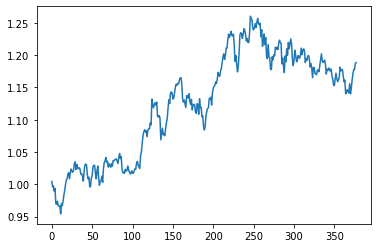

epoch :  73 time_idx :  0 loss_reg :  tensor(0.6892, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.0779) precision :  tensor(0.5000) return_rate tensor(0.0024) com_return_rate tensor(1.0024)
epoch :  73 time_idx :  100 loss_reg :  tensor(0.7202, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0032) com_return_rate tensor(1.0850)
epoch :  73 time_idx :  200 loss_reg :  tensor(0.6971, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2088) precision :  tensor(0.8511) return_rate tensor(0.0061) com_return_rate tensor(1.2089)
epoch :  73 time_idx :  300 loss_reg :  tensor(0.6888, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2255) precision :  tensor(0.7353) return_rate tensor(0.0032) com_return_rate tensor(1.2164)


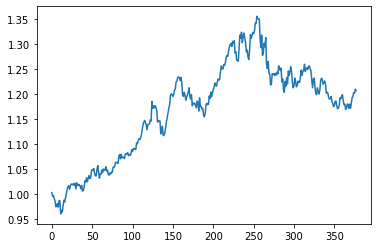

epoch :  74 time_idx :  0 loss_reg :  tensor(0.6900, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(0.1157) precision :  tensor(0.5294) return_rate tensor(0.0074) com_return_rate tensor(1.0074)
epoch :  74 time_idx :  100 loss_reg :  tensor(0.7217, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0021) com_return_rate tensor(1.1830)
epoch :  74 time_idx :  200 loss_reg :  tensor(0.7019, grad_fn=<AddBackward0>) acc :  tensor(0.4471) mcc :  tensor(-0.2305) precision :  tensor(0.8409) return_rate tensor(0.0082) com_return_rate tensor(1.3840)
epoch :  74 time_idx :  300 loss_reg :  tensor(0.6878, grad_fn=<AddBackward0>) acc :  tensor(0.6235) mcc :  tensor(0.3055) precision :  tensor(0.7879) return_rate tensor(0.0032) com_return_rate tensor(1.4235)


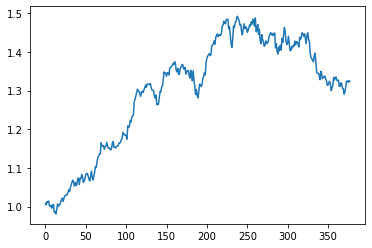

epoch :  75 time_idx :  0 loss_reg :  tensor(0.6907, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0998) precision :  tensor(0.5128) return_rate tensor(0.0050) com_return_rate tensor(1.0050)
epoch :  75 time_idx :  100 loss_reg :  tensor(0.7229, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0049) com_return_rate tensor(1.1182)
epoch :  75 time_idx :  200 loss_reg :  tensor(0.7001, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0039) com_return_rate tensor(1.2657)
epoch :  75 time_idx :  300 loss_reg :  tensor(0.6896, grad_fn=<AddBackward0>) acc :  tensor(0.6000) mcc :  tensor(0.2694) precision :  tensor(0.7742) return_rate tensor(0.0029) com_return_rate tensor(1.3124)


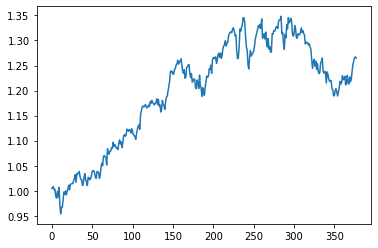

epoch :  76 time_idx :  0 loss_reg :  tensor(0.6895, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.0675) precision :  tensor(0.5000) return_rate tensor(0.0013) com_return_rate tensor(1.0013)
epoch :  76 time_idx :  100 loss_reg :  tensor(0.7232, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0031) com_return_rate tensor(1.1353)
epoch :  76 time_idx :  200 loss_reg :  tensor(0.7004, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0043) com_return_rate tensor(1.2771)
epoch :  76 time_idx :  300 loss_reg :  tensor(0.6897, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2029) precision :  tensor(0.7105) return_rate tensor(0.0036) com_return_rate tensor(1.3477)


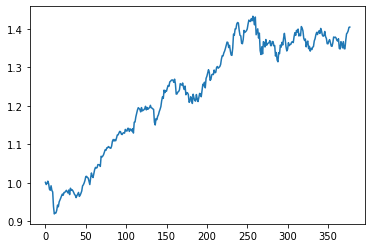

epoch :  77 time_idx :  0 loss_reg :  tensor(0.6907, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0452) precision :  tensor(0.4857) return_rate tensor(-0.0017) com_return_rate tensor(0.9983)
epoch :  77 time_idx :  100 loss_reg :  tensor(0.7225, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0018) com_return_rate tensor(1.0778)
epoch :  77 time_idx :  200 loss_reg :  tensor(0.6995, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.2088) precision :  tensor(0.8511) return_rate tensor(0.0120) com_return_rate tensor(1.1986)
epoch :  77 time_idx :  300 loss_reg :  tensor(0.6879, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2624) precision :  tensor(0.7500) return_rate tensor(0.0004) com_return_rate tensor(1.1538)


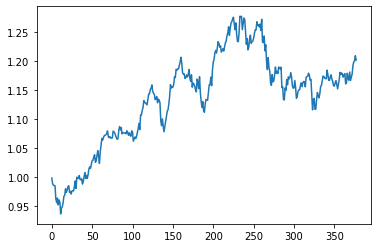

epoch :  78 time_idx :  0 loss_reg :  tensor(0.6903, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0964) precision :  tensor(0.5135) return_rate tensor(-0.0072) com_return_rate tensor(0.9928)
epoch :  78 time_idx :  100 loss_reg :  tensor(0.7238, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0062) com_return_rate tensor(1.0584)
epoch :  78 time_idx :  200 loss_reg :  tensor(0.7007, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(-0.2159) precision :  tensor(0.8478) return_rate tensor(0.0055) com_return_rate tensor(1.1193)
epoch :  78 time_idx :  300 loss_reg :  tensor(0.6888, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2875) precision :  tensor(0.7812) return_rate tensor(0.0073) com_return_rate tensor(1.1823)


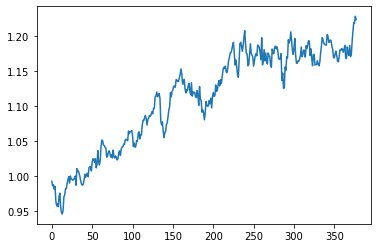

epoch :  79 time_idx :  0 loss_reg :  tensor(0.6899, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0931) precision :  tensor(0.5143) return_rate tensor(0.0013) com_return_rate tensor(1.0013)
epoch :  79 time_idx :  100 loss_reg :  tensor(0.7225, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0032) com_return_rate tensor(1.0488)
epoch :  79 time_idx :  200 loss_reg :  tensor(0.7010, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.1878) precision :  tensor(0.8600) return_rate tensor(-0.0005) com_return_rate tensor(1.0867)
epoch :  79 time_idx :  300 loss_reg :  tensor(0.6887, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.2745) precision :  tensor(0.7647) return_rate tensor(0.0064) com_return_rate tensor(1.1102)


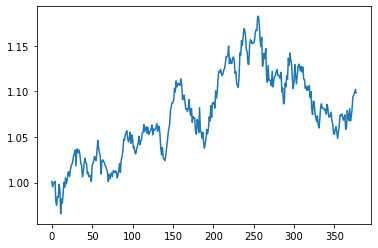

epoch :  80 time_idx :  0 loss_reg :  tensor(0.6908, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0416) precision :  tensor(0.4848) return_rate tensor(-0.0010) com_return_rate tensor(0.9990)
epoch :  80 time_idx :  100 loss_reg :  tensor(0.7223, grad_fn=<AddBackward0>) acc :  tensor(0.1882) mcc :  tensor(nan) precision :  tensor(0.1882) return_rate tensor(-0.0006) com_return_rate tensor(1.0195)
epoch :  80 time_idx :  200 loss_reg :  tensor(0.7028, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0069) com_return_rate tensor(1.0789)
epoch :  80 time_idx :  300 loss_reg :  tensor(0.6913, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2657) precision :  tensor(0.7857) return_rate tensor(-0.0014) com_return_rate tensor(1.0738)


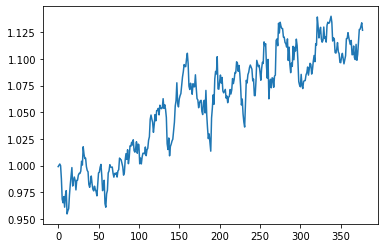

Epochs :  80 Iterations :  31428 Loss :  0.6944042828279672 ACC :  0.5062462243721965 MCC :  nan Precision :  0.5222692619433108
epoch :  81 time_idx :  0 loss_reg :  tensor(0.6913, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.0642) precision :  tensor(0.5000) return_rate tensor(-0.0064) com_return_rate tensor(0.9936)
epoch :  81 time_idx :  100 loss_reg :  tensor(0.7293, grad_fn=<AddBackward0>) acc :  tensor(0.2118) mcc :  tensor(0.0748) precision :  tensor(0.1928) return_rate tensor(-0.0090) com_return_rate tensor(1.0722)
epoch :  81 time_idx :  200 loss_reg :  tensor(0.7020, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.1878) precision :  tensor(0.8600) return_rate tensor(0.0078) com_return_rate tensor(1.2424)
epoch :  81 time_idx :  300 loss_reg :  tensor(0.6933, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.1772) precision :  tensor(0.7308) return_rate tensor(0.0061) com_return_rate tensor(1.2020)


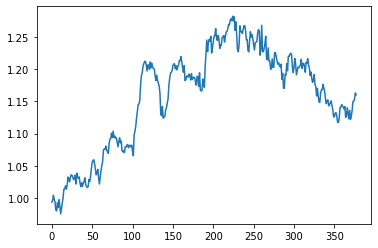

epoch :  82 time_idx :  0 loss_reg :  tensor(0.6912, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(0.0381) precision :  tensor(0.4839) return_rate tensor(-0.0058) com_return_rate tensor(0.9942)
epoch :  82 time_idx :  100 loss_reg :  tensor(0.7277, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0121) com_return_rate tensor(1.1129)
epoch :  82 time_idx :  200 loss_reg :  tensor(0.7041, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.1947) precision :  tensor(0.8571) return_rate tensor(0.0070) com_return_rate tensor(1.1525)
epoch :  82 time_idx :  300 loss_reg :  tensor(0.6928, grad_fn=<AddBackward0>) acc :  tensor(0.5412) mcc :  tensor(0.1388) precision :  tensor(0.6875) return_rate tensor(0.0061) com_return_rate tensor(1.1436)


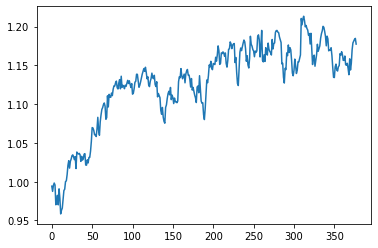

epoch :  83 time_idx :  0 loss_reg :  tensor(0.6919, grad_fn=<AddBackward0>) acc :  tensor(0.5059) mcc :  tensor(-0.0028) precision :  tensor(0.4571) return_rate tensor(0.0004) com_return_rate tensor(1.0004)
epoch :  83 time_idx :  100 loss_reg :  tensor(0.7297, grad_fn=<AddBackward0>) acc :  tensor(0.2000) mcc :  tensor(0.0525) precision :  tensor(0.1905) return_rate tensor(-0.0072) com_return_rate tensor(1.0742)


In [ ]:
model.train()

In [1]:
model.test()

NameError: ignored

In [27]:
model.train()

epoch :  0 time_idx :  0 loss_reg :  tensor(1.0154, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(0.0704) precision :  tensor(0.4828)
epoch :  0 time_idx :  10 loss_reg :  tensor(0.8855, grad_fn=<AddBackward0>) acc :  tensor(0.6706) mcc :  tensor(0.0273) precision :  tensor(0.2857)


KeyboardInterrupt: ignored

epoch :  0 time_idx :  0 loss_reg :  tensor(1.1058, grad_fn=<AddBackward0>) acc :  tensor(0.4118) mcc :  tensor(0.1317) precision :  tensor(0.9667)
epoch :  0 time_idx :  10 loss_reg :  tensor(1.0207, grad_fn=<AddBackward0>) acc :  tensor(0.5176) mcc :  tensor(-0.0338) precision :  tensor(0.3438)
epoch :  0 time_idx :  20 loss_reg :  tensor(0.9931, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(-0.0620) precision :  tensor(0.0690)
epoch :  0 time_idx :  30 loss_reg :  tensor(1.0489, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0367) precision :  tensor(0.4737)
epoch :  0 time_idx :  40 loss_reg :  tensor(1.0074, grad_fn=<AddBackward0>) acc :  tensor(0.5647) mcc :  tensor(-0.1562) precision :  tensor(0.)
epoch :  0 time_idx :  50 loss_reg :  tensor(0.9746, grad_fn=<AddBackward0>) acc :  tensor(0.5529) mcc :  tensor(0.0534) precision :  tensor(0.3714)


ValueError: ignored

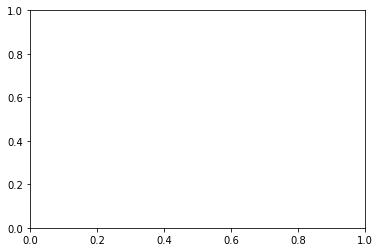

In [21]:
model.test()

In [51]:
model.return_rate.shape

(1, 54)

In [ ]:
ㄴmodel.train()

epoch :  0 time_idx :  0 loss_reg :  tensor(0.9800, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(-0.0182) precision :  tensor(0.4286)
epoch :  0 time_idx :  10 loss_reg :  tensor(0.7893, grad_fn=<AddBackward0>) acc :  tensor(0.7412) mcc :  tensor(0.1518) precision :  tensor(0.5000)
epoch :  0 time_idx :  20 loss_reg :  tensor(0.8372, grad_fn=<AddBackward0>) acc :  tensor(0.6118) mcc :  tensor(0.0862) precision :  tensor(0.8491)
epoch :  0 time_idx :  30 loss_reg :  tensor(1.1048, grad_fn=<AddBackward0>) acc :  tensor(0.1294) mcc :  tensor(nan) precision :  tensor(0.1294)
epoch :  0 time_idx :  40 loss_reg :  tensor(0.7752, grad_fn=<AddBackward0>) acc :  tensor(0.7059) mcc :  tensor(0.0758) precision :  tensor(0.9194)
epoch :  0 time_idx :  50 loss_reg :  tensor(0.7943, grad_fn=<AddBackward0>) acc :  tensor(0.5882) mcc :  tensor(0.2243) precision :  tensor(0.8810)
epoch :  0 time_idx :  60 loss_reg :  tensor(0.7945, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  ten

In [ ]:
model.train()

epoch :  0 time_idx :  0 loss_reg :  tensor(1.1775, grad_fn=<AddBackward0>) acc :  tensor(0.4706) mcc :  tensor(0.1005)
epoch :  0 time_idx :  10 loss_reg :  tensor(0.8964, grad_fn=<AddBackward0>) acc :  tensor(0.6941) mcc :  tensor(0.1277)
epoch :  0 time_idx :  20 loss_reg :  tensor(0.8335, grad_fn=<AddBackward0>) acc :  tensor(0.7294) mcc :  tensor(0.0440)
epoch :  0 time_idx :  30 loss_reg :  tensor(1.1583, grad_fn=<AddBackward0>) acc :  tensor(0.1176) mcc :  tensor(-0.2830)
epoch :  0 time_idx :  40 loss_reg :  tensor(0.8001, grad_fn=<AddBackward0>) acc :  tensor(0.7059) mcc :  tensor(0.0022)
epoch :  0 time_idx :  50 loss_reg :  tensor(0.8670, grad_fn=<AddBackward0>) acc :  tensor(0.3647) mcc :  tensor(-0.1457)
epoch :  0 time_idx :  60 loss_reg :  tensor(0.8143, grad_fn=<AddBackward0>) acc :  tensor(0.4824) mcc :  tensor(-0.0628)
epoch :  0 time_idx :  70 loss_reg :  tensor(0.7893, grad_fn=<AddBackward0>) acc :  tensor(0.5294) mcc :  tensor(-0.0966)
epoch :  0 time_idx :  80 los